In [1]:
from gurobipy import *
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pysd
import numpy as np
import geopandas as gp
import zipfile
import requests
import networkx as nx
import matplotlib.cm
import math
from math import radians, sin, cos, acos
from geopy.distance import geodesic
import requests
from bs4 import BeautifulSoup
from osgeo import ogr, osr
import matplotlib.cm as cmx
import matplotlib.colors as colors
from Circles.circles import circle
from shapely.geometry import Polygon, Point
from descartes import PolygonPatch
from shapely.ops import cascaded_union
import pickle
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import warnings
from copy import deepcopy
import copy
warnings.filterwarnings("ignore")


# Import Network Data (Shapefiles, Nodes, Edges)

In [3]:
#Import Shapefiles
provinces = gp.GeoDataFrame.from_file(r"Shapefiles/Provinces.shp")
# aklan = gp.GeoDataFrame.from_file(r"Shapefiles/Aklan/Aklan.shp")
# antique = gp.GeoDataFrame.from_file(r"Shapefiles/Antique/Antique.shp")
# capiz = gp.GeoDataFrame.from_file(r"Shapefiles/Capiz/Capiz.shp")
# guimaras = gp.GeoDataFrame.from_file(r"Shapefiles/Guimaras/Guimaras.shp")
# iloilo = gp.GeoDataFrame.from_file(r"Shapefiles/Iloilo/Iloilo.shp")
# negros = gp.GeoDataFrame.from_file(r"Shapefiles/Negros/Negros Occidental.shp")

#Combine provincial shapefiles to form regional shapefile
# regionvi = pd.concat([aklan, antique, capiz, guimaras, iloilo, negros], ignore_index=True)
# regionvi = pd.concat([iloilo], ignore_index=True)
# regionvi = regionvi.dissolve(by='NAME_2', as_index=False)
# regionvi.to_file("regionvi.shp")

In [46]:
provinces
aa = provinces.loc[provinces['REGION'].isin(['Western Visayas (Region VI)', 'Eastern Visayas (Region VIII)', 'Central Visayas (Region VII)'])]
iloilo = aa.loc[aa['PROVINCE'].isin(['Iloilo'])]
westernv = aa.loc[aa['REGION'].isin(['Western Visayas (Region VI)'])]
visayas = aa
iloilo.to_file("iloilo.shp")
westernv.to_file("westernv.shp")
visayas.to_file("visayas.shp")

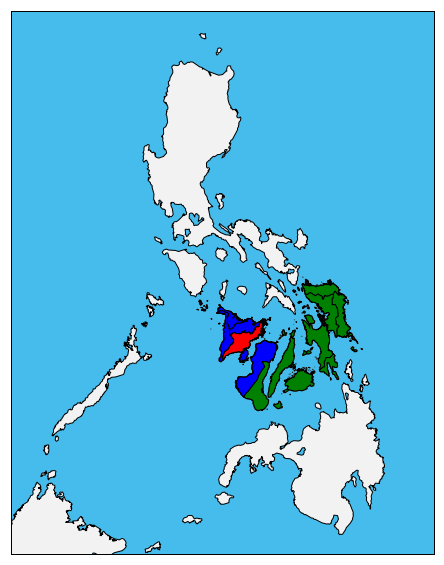

In [53]:
#create basemap
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(resolution='i', # c, l, i, h, f or None
            projection='merc',
#             lat_0=10.75, lon_0=122.5,
            llcrnrlon=116, llcrnrlat= 5, urcrnrlon=128, urcrnrlat=20)

#draw map boundaries
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

#draw town borders
m.readshapefile('iloilo', 'geometry', linewidth = 1, color='gray')

patches = []
for shape in m.geometry:
    patches.append( Polygon(np.array(shape), True) )
  
ax.add_collection(PatchCollection(patches, facecolor= 'r', edgecolor='k', linewidths=1., zorder=4))

#draw town borders
m.readshapefile('westernv', 'westernv', linewidth = 1, color='gray')

patches2 = []
for shape in m.westernv:
    patches2.append( Polygon(np.array(shape), True) )
  
ax.add_collection(PatchCollection(patches2, facecolor= 'b', edgecolor='k', linewidths=1., zorder=3))


m.readshapefile('visayas', 'visayas', linewidth = 1, color='gray')

patches3 = []
for shape in m.visayas:
    patches3.append( Polygon(np.array(shape), True) )
  
ax.add_collection(PatchCollection(patches3, facecolor= 'g', edgecolor='k', linewidths=1., zorder=2))

plt.show()

plt.show()




In [3]:
#Import towns data (nodes)
towns = pd.read_csv('municipality_profiles.csv')
towns = towns.loc[towns['Province'] == 'ILOILO']
towns = towns.reset_index(drop = True)

#Import roads data (edges)
roads = pd.read_csv('road_distancesIloilo.csv')
roads['startlon'] = ''
roads['startlat'] = ''
roads['endlon'] = ''
roads['endlat'] = ''
for i in range(len(roads)):
    for j in range(len(towns)):
        if roads['Start Code'][i] == towns['Code'][j]:
            roads['startlon'][i] = towns['longitude'][j]
            roads['startlat'][i] = towns['latitude'][j]
        if roads['End Code'][i] == towns['Code'][j]:
            roads['endlon'][i] = towns['longitude'][j]
            roads['endlat'][i] = towns['latitude'][j]

# #import sea data (edges)
# seas = pd.read_csv('sea_supply_routes.csv')
# regionviseas = pd.DataFrame(columns=list(seas))
# for i in range(len(seas)):
#     for j in range(len(towns)):
#         if seas.iloc[i,0] == towns['Code'].tolist()[j]:
#             for k in range(len(towns)):
#                 if seas.iloc[i,1] == towns['Code'].tolist()[k]:
# #             if seas.iloc[i,1] in roads['Start Code'].tolist():
#                     regionviseas = regionviseas.append(seas.iloc[i])
# regionviseas = regionviseas.drop_duplicates()
# regionviseas = regionviseas.reset_index(drop=True)

### Network Visualization based on raw data

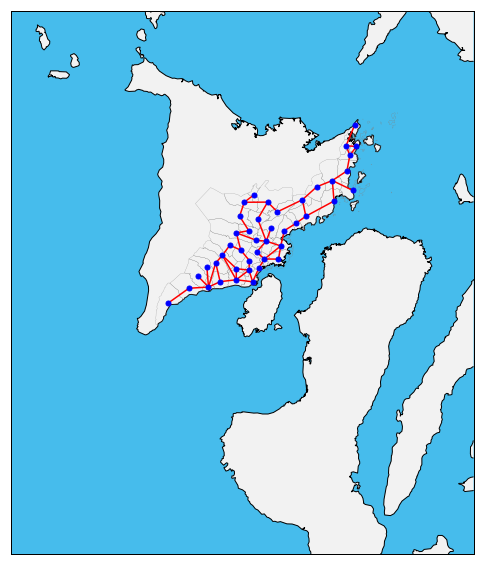

In [4]:
#create basemap
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            lat_0=10.75, lon_0=122.5,
            llcrnrlon=121.2, llcrnrlat= 9.2, urcrnrlon=123.8, urcrnrlat=12.2)

#draw map boundaries
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

#draw town centers
x,y = m(towns['longitude'].tolist(), towns['latitude'].tolist())
m.plot(x, y, 'bo', markersize=5, zorder=5)

#draw town borders
m.readshapefile('regionvi', "towns", linewidth = 0.2, color='gray')

#draw roads
for i in range(len(roads)):
    roadlon = [roads['startlon'][i],roads['endlon'][i]]
    roadlat = [roads['startlat'][i],roads['endlat'][i]]
    q,r = m(roadlon,roadlat)
    m.plot(q,r, marker=None, color='red')

## Create Graph

In [5]:
Q = nx.Graph()

#cost of shipping (per FFP item per km)
truck = .5
roro = 0.25

#add nodes
for i in range(len(towns)):
    Q.add_node(towns['Code'][i],name=towns['Municipality'][i], pos=(towns['longitude'][i],towns['latitude'][i]),province=towns['Province'][i],population=towns['Population'][i],lon=towns['longitude'][i],lat=towns['latitude'][i])

#add edges (roads)
for i in range(len(roads)):
    Q.add_edge(int(roads['Start Code'][i]),int(roads['End Code'][i]),length=roads['Distance (km)'][i],traveltime=roads['Distance (km)'][i]/60,vessel='truck',cost=roads['Distance (km)'][i]*truck)

# #add edges (seas)
# for i in range(len(regionviseas)):
#     Q.add_edge(int(regionviseas['Origin'][i]),int(regionviseas['Destination'][i]),length=regionviseas['Distance.miles'][i]*1.60934,traveltime=regionviseas['Distance.miles'][i]*1.60934/29.632,vessel='ro-ro',cost=roads['Distance (km)'][i]*roro)

    

## Graph Visualization

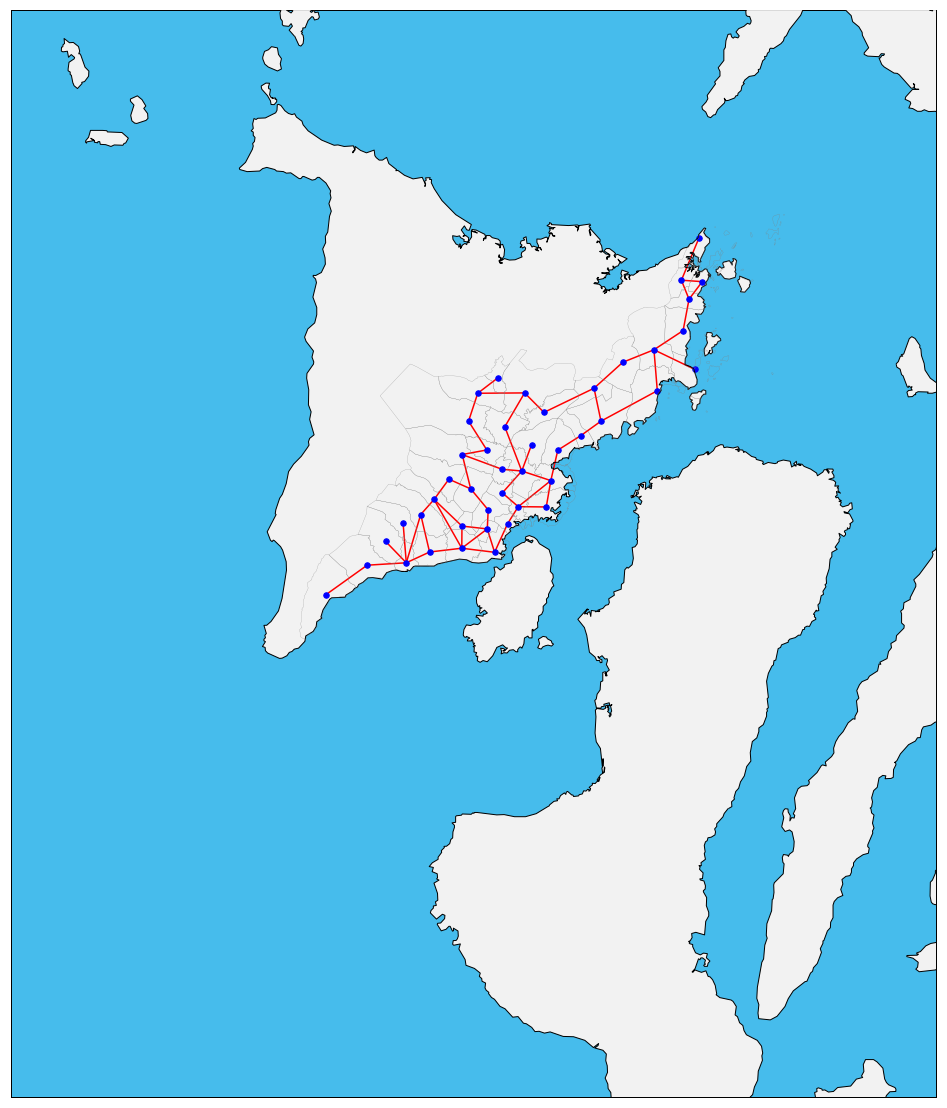

In [6]:
#create basemap
fig, ax = plt.subplots(figsize=(20,20))
qmap = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            lat_0=10.75, lon_0=122.5,
            llcrnrlon=121.2, llcrnrlat= 9.2, urcrnrlon=123.8, urcrnrlat=12.2)

#map town centers
lon = nx.get_node_attributes(Q,'lon')
lat = nx.get_node_attributes(Q,'lat')
lonlist = [v for v in lon.values()]
latlist = [v for v in lat.values()]
x,y = qmap(lonlist, latlist)
nodelist = nx.nodes(Q)
pos = {}
for i in range(len(nodelist)):
    pos[nodelist[i]]=(x[i],y[i])

#draw network
nx.draw_networkx(Q,pos,node_size=30,node_color='blue',with_labels=False,edge_color='red',width=1.5)

#draw map boundaries and town borders
qmap.drawmapboundary(fill_color='#46bcec', zorder=-1)
qmap.fillcontinents(color='#f2f2f2',lake_color='#46bcec', zorder=0)
qmap.drawcoastlines()
qmap.readshapefile('regionvi', "towns", linewidth = 0.2, color='gray')

# draw the map
plt.show()


## Design Functions

In [236]:
def listcoordinates(latitude, longitude):
    '''list the latitude and longitude of the towns'''
    coord = []
    latcoord = latitude.tolist()
    loncoord = longitude.tolist()
    for i in range(len(latcoord)):
        coord.append([float(latcoord[i]),float(loncoord[i])])
        i = i+1
    return coord

def extractbesttrack(typhooncode):
    '''extracts the actual track of the typhoon including latitude, longitude, intensity, and time'''
    stormlink = 'http://rammb.cira.colostate.edu/products/tc_realtime/storm.asp?storm_identifier=' + typhooncode
    res = requests.get(stormlink)
    soup = BeautifulSoup(res.content,'lxml')
    table = soup.find_all('table')
    besttrackdf = pd.read_html(str(table))
    besttrackdf=besttrackdf[1]
    besttrackdf = besttrackdf.rename(columns=besttrackdf.iloc[0]).drop(besttrackdf.index[0]).reset_index(drop=True)
    for i in range(len(besttrackdf)):
        besttrackdf.loc[i,'Time']= pd.to_datetime(besttrackdf.loc[i,'Synoptic Time'],format='%Y%m%d%H%M' )
    besttrackdf = besttrackdf.drop(['Synoptic Time'],1)
    besttrackdf = besttrackdf[['Time','Latitude','Longitude','Intensity']]
    for i in range(len(besttrackdf)):
        besttrackdf.loc[i,'Latitude'] = float(besttrackdf.loc[i,'Latitude'])
        besttrackdf.loc[i,'Longitude'] = float(besttrackdf.loc[i,'Longitude'])
        besttrackdf.loc[i,'Intensity'] = float(besttrackdf.loc[i,'Intensity'])
    return besttrackdf

def distance(a,b):  
    '''shortest distance in km of between two points on earths surface'''
    if a[0] == 0 or b[0] == 0 or a[1] == 0 or b[1] == 0:
        return 1000000000
    else:
        return geodesic((a[0],a[1]),(b[0],b[1])).km

def WindSpeedCoeff(radius, intensity):
    '''Returns the wind speed coefficient given the radius (how far is the point from the center of the typhoon) and the intensity of the typhoon'''
    return min(1,0.004 * intensity * math.sqrt(((18*(intensity/240))/radius)**(3))* math.e**(1-(18*(intensity/240)/radius)**(3)))

def listintensity(DF):
    '''Takes forecast intensity from the dataframe, converts to kph and returns a list'''
    a = list(DF.Intensity.apply(float))
    a = [1.60934*i for i in a]
    return a

def DPdemandcoeff(typhooncoords, typhoonintensity, DPcoord):
    '''Inputs the DP coordinate, and the path of the typhoon (location and intensity). It returns the maximum wind speed coefficient'''
    towndistance = []
    towndemand = []
    for i in range(len(typhooncoords)):
        towndistance.append(distance(typhooncoords[i], DPcoord))
    for i in range(len(towndistance)):
        towndemand.append(WindSpeedCoeff(towndistance[i],typhoonintensity[i]))
    return max(towndemand)

def demand(townloc, townpop, typhoontrack):
    '''Calculates demand for the DP'''
    DPdemand = []
    for i in range(len(townpop)):
        DPdemand.append(round(townpop[i]*DPdemandcoeff(listcoordinates(typhoontrack['Latitude'],typhoontrack['Longitude']),listintensity(typhoontrack),townloc[i])))
    return DPdemand

def generatebesttrackcone(df,steps,m):
    '''Generates the forecast cone. The higher the number of steps, the smoother the shape of the cone. m is the basemap'''
#     uncradius = [.1,157.42,240.76,333.36,388.92,601.9,787.1,926] 
    listshapes = []
    for i in range(len(df)):
        df.loc[i,'Radius'] = r33(int(df.loc[i,'Intensity']))/1.65
    #idjara
    df = df[(df[['Latitude','Longitude']] != 0).all(axis=1)]
    newdf = interpolateforecastdata(df, steps)
    for i in range(len(newdf)):
        casa = circle(m, float(newdf.Longitude[i]), float(newdf.Latitude[i]), newdf.Radius[i])
        pol = Polygon(casa) 
        listshapes.append(pol)
    u = cascaded_union(listshapes)
    return u

def generatebesttrackcone2(df,steps,m):
    '''Generates the forecast cone. The higher the number of steps, the smoother the shape of the cone. m is the basemap'''
#     uncradius = [.1,157.42,240.76,333.36,388.92,601.9,787.1,926] 
    listshapes = []
    for i in range(len(df)):
        df.loc[i,'Radius'] = rmw(int(df.loc[i,'Intensity']))/1.60934
    df = df[(df[['Latitude','Longitude']] != 0).all(axis=1)]
    newdf = interpolateforecastdata(df, steps)
    for i in range(len(newdf)):
        casa = circle(m, float(newdf.Longitude[i]), float(newdf.Latitude[i]), newdf.Radius[i])
        pol = Polygon(casa) 
        listshapes.append(pol)
    u = cascaded_union(listshapes)
    return u

def landfall(lat, lon):
    '''Determines if the storm center is inside the Philippines'''
    if 4.24 <= lat <= 21.07 and 116.53 <= lon <= 126.36:
        return 'Landfall'
    else:
        return ''

def islandfall(forecast):
    '''If the storm center coordinate is inside the Philippines, then it labels so'''
    for i in range(len(forecast.Latitude)):
        forecast.loc[i,'Landfall'] = landfall(float(forecast.Latitude[i]),float(forecast.Longitude[i]))
    return forecast

def rmw(intensity):
    '''Calculates the radius of maximum wind (in KM) given typhoon intensity (mph)'''
    # below cat 1
    if intensity < 74:
        return 0.1
    # cat 1 and cat 2
    elif intensity < 111:
        return 55.5
    # cat 3 and cat 4
    elif intensity < 157:
        return 47
    else:
        return 27.8

def r33(intensity):
    '''Calculates the radius of 33 m/s winds (in Km), which defines the area that sustains damage'''
    # below cat 1
    if intensity < 74:
        return 0.1
    # cat 1 and cat 2
    elif intensity < 111:
        return 74
    elif intensity < 130:
        return 96
    else:
        return 94

def interpolateforecastdata(besttrackdf,steps):
    '''interpolate the points for the forecast data. The number of steps indicate the number of time steps you want to split each duration to.'''
    newbesttrackdf = besttrackdf
    for i in range(len(besttrackdf)-1):
        intermediate = pd.DataFrame(columns = list(besttrackdf), index=range(steps-1))
        for col in list(besttrackdf):
            if type(besttrackdf.loc[i,col]) == str:
                diff = (float(besttrackdf.loc[i,col]) - float(besttrackdf.loc[i+1,col]))/steps
            else:
                diff = (besttrackdf.loc[i,col] - besttrackdf.loc[i+1,col])/steps
            for j in range(steps-1):
                if type(besttrackdf.loc[i,col]) == str:
                    intermediate.loc[j,col] = float(besttrackdf.loc[i,col])-diff*(j+1)
                else:
                    intermediate.loc[j,col] = besttrackdf.loc[i,col]-diff*(j+1)
        newbesttrackdf = pd.concat([newbesttrackdf.ix[:i+(steps-1)*i], intermediate, newbesttrackdf.ix[i+(steps-1)*i+1:]]).reset_index(drop=True)
    return newbesttrackdf




## Extract Historical Typhoon Track Data

In [237]:
#Extract the best track of the typhoon 
besttrackdf = extractbesttrack('WP312013')
besttrackdf = besttrackdf[13:16].reset_index(drop=True)

# interpolate the points between forecast hours for increased accuracy. Assume linear behaviour.
# newbesttrackdf = interpolateforecastdata(besttrackdf, 15)


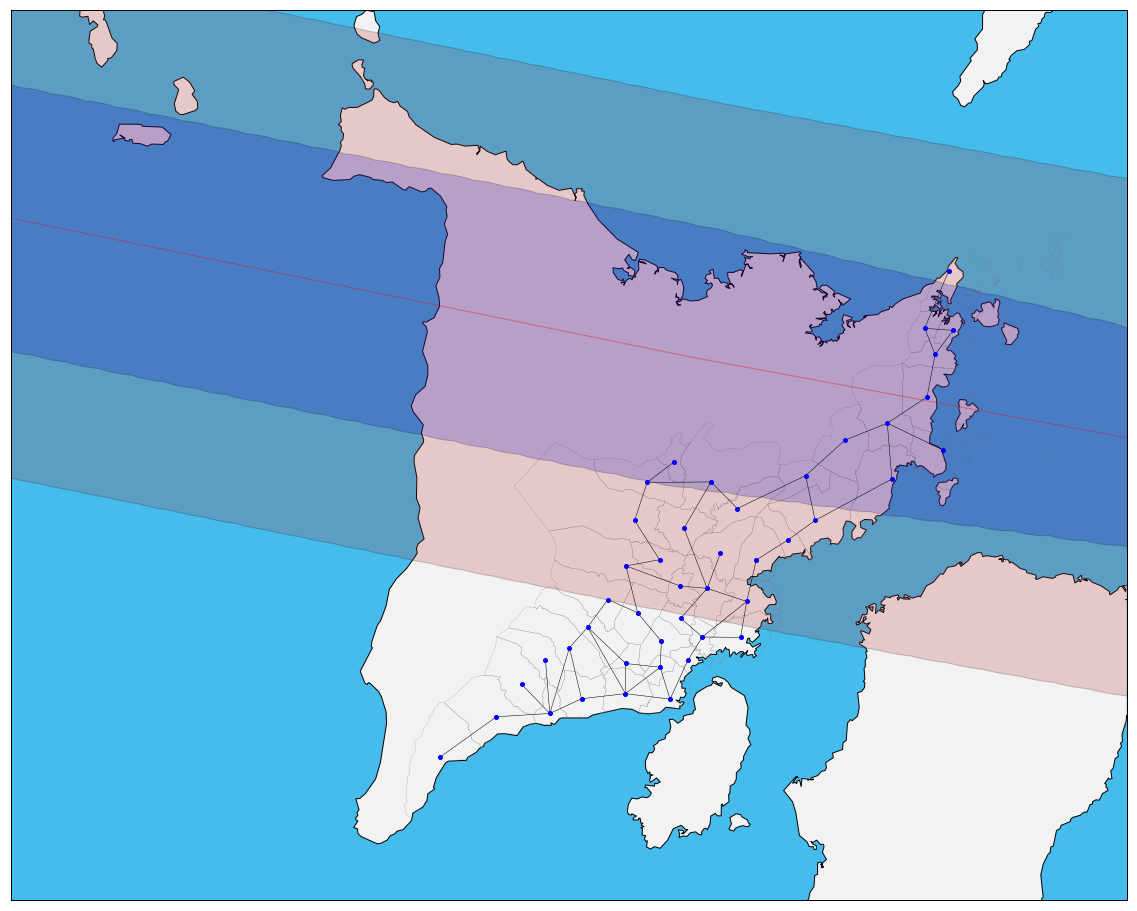

In [239]:
from Circles.circles import circle
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from descartes import PolygonPatch
import numpy as np

#create basemap

lonmin = 121.2
lonmax = 123.5
latmin = 10.3
latmax = 12.1

fig, ax = plt.subplots(figsize=(20,20))
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            llcrnrlon=lonmin, llcrnrlat= latmin, urcrnrlon=lonmax, urcrnrlat=latmax)

#draw best track
besttrackdf = besttrackdf[(besttrackdf[['Latitude','Longitude']] != 0).all(axis=1)]
q,r = m(besttrackdf['Longitude'].tolist(), besttrackdf['Latitude'].tolist())
m.plot(q, r, marker="o", markersize=0.1, linewidth=1, zorder=2, color = 'red', alpha = 0.4)

#generate best track affected area
forecastcone2 = generatebesttrackcone(besttrackdf,30,m)
mapforecastcone2 = PolygonPatch(forecastcone2, fc='#B22222', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone2)

#generate best track affected area (supply destroyed)
forecastcone3 = generatebesttrackcone2(besttrackdf,30,m)
mapforecastcone3 = PolygonPatch(forecastcone3, fc='#0000CD', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone3)

#draw map boundaries
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

#draw town centers
x,y = m(towns['longitude'].tolist(), towns['latitude'].tolist())
m.plot(x, y, 'bo', markersize=4, zorder=5)

#draw town borders
m.readshapefile('regionvi', "towns", linewidth = 0.2, color='gray')

#draw roads
for i in range(len(roads)):
    roadlon = [roads['startlon'][i],roads['endlon'][i]]
    roadlat = [roads['startlat'][i],roads['endlat'][i]]
    q,r = m(roadlon,roadlat)
    m.plot(q,r, marker=None, linewidth = 0.5, color='black')



# Define Functions

In [240]:
def rmw(intensity):
    '''Calculates the radius of maximum wind (in KM) given typhoon intensity (mph)'''
    # below cat 1
    if intensity < 74:
        return 0
    # cat 1 and cat 2
    elif intensity < 111:
        return 55.5
    # cat 3 and cat 4
    elif intensity < 157:
        return 47
    else:
        return 27.8

def r33(intensity):
    '''Calculates the radius of 33 m/s winds (in Km), which defines the area that sustains damage'''
    # below cat 1
    if intensity < 74:
        return 0
    # cat 1 and cat 2
    elif intensity < 111:
        return 74
    elif intensity < 130:
        return 96
    else:
        return 94

def WindSpeedCoeff(radius, intensity):
    '''Returns the wind speed coefficient given the radius (how far is the point from the center of the typhoon) and the intensity of the typhoon'''
    if rmw(intensity) == None:
        return 0
    else:
        return 0.004 * intensity * math.sqrt(((rmw(intensity)/radius)**(3))* math.e**(1-(rmw(intensity)/radius)**(3)))

def distance(a,b):  
    '''shortest distance in km of between two points on earths surface'''
    return geodesic((a[0],a[1]),(b[0],b[1])).km

def DPdemandcoeff(typhooncoords, typhoonintensity, DPcoord):
    '''Inputs the DP coordinate, and the path of the typhoon (location and intensity). It returns the maximum wind speed coefficient'''
    towndistance = []
    towndemand = []
    for i in range(len(typhooncoords)):
        towndistance.append(distance(typhooncoords[i], DPcoord))
    if min(towndistance)*1.60934 <= r33(typhoonintensity[np.argmin(towndistance)]):
        for i in range(len(towndistance)):
            towndemand.append(WindSpeedCoeff(towndistance[i],typhoonintensity[i]))
        return max(towndemand)
    else:
        return 0

def preptime(typhooncoords, typhoonintensity, DPcoord, forecasthour):
    '''Inputs the DP coordinate, and the path of the typhoon (location and intensity). It returns the minimum preparation time required'''
    k = 0
    while k < len(typhooncoords):
        if distance(typhooncoords[k], DPcoord)*1.60934 <= r33(typhoonintensity[k]):
            timeprep = math.floor(forecasthour[k]/6)*6
            break
        else:
            k += 1
    if k == len(typhooncoords):
#         timeprep = (math.floor(k/10)-1)*6
        timeprep = 1000
    return timeprep

def prep(townloc, typhoontrack):
    '''Calculates minimum preparation time for each location (before typhoon hits)'''
    preptimelist = []
    for i in range(len(townloc)):
        preptimelist.append(
            preptime(listcoordinates(typhoontrack['Latitude'],typhoontrack['Longitude']),
                     listintensity(typhoontrack),
                     townloc[i], 
                     listforecasthour(typhoontrack)))
    return pd.DataFrame(preptimelist)


def demand(townloc, townpop, typhoontrack):
    '''Calculates demand for the DP'''
    DPdemand = []
    for i in range(len(townpop)):
        DPdemand.append(
            round((townpop[i]/5)*DPdemandcoeff(listcoordinates(typhoontrack['Latitude'],typhoontrack['Longitude']),listintensity(typhoontrack),townloc[i])))
    return pd.DataFrame(DPdemand)

def interpolateforecastdata(besttrackdf,steps):
    '''interpolate the points for the forecast data. The number of steps indicate the number of time steps you want to split each duration to.'''
    besttrackdf = besttrackdf.reset_index(drop=True)
    newbesttrackdf = besttrackdf
    for i in range(len(besttrackdf)-1):
        intermediate = pd.DataFrame(columns = list(besttrackdf), index=range(steps-1))
        for col in list(besttrackdf):
            if type(besttrackdf.loc[i,col]) == str:
                diff = (float(besttrackdf.loc[i,col]) - float(besttrackdf.loc[i+1,col]))/steps
            else:
                diff = (besttrackdf.loc[i,col] - besttrackdf.loc[i+1,col])/steps
            for j in range(steps-1):
                if type(besttrackdf.loc[i,col]) == str:
                    intermediate.loc[j,col] = float(besttrackdf.loc[i,col])-diff*(j+1)
                else:
                    intermediate.loc[j,col] = besttrackdf.loc[i,col]-diff*(j+1)
        newbesttrackdf = pd.concat([newbesttrackdf.ix[:i+(steps-1)*i], intermediate, newbesttrackdf.ix[i+(steps-1)*i+1:]]).reset_index(drop=True)
    return newbesttrackdf

def listcoordinates(latitude, longitude):
    '''list the latitude and longitude of the towns'''
    coord = []
    latcoord = latitude.tolist()
    loncoord = longitude.tolist()
    for i in range(len(latcoord)):
        coord.append([float(latcoord[i]),float(loncoord[i])])
        i = i+1
    return coord

def listintensity(DF):
    '''Takes forecast intensity from the dataframe, and returns a list'''
    a = list(DF.Intensity.apply(float))
    return a

def listforecasthour(DF):
    '''Takes forecast intensity from the dataframe, and returns a list'''
    a = list(DF.ForecastHour.apply(float))
    return a

def SupplyDestroyed(typhooncoords, typhoonintensity, DPcoord):
    '''Inputs the DP coordinate, and the path of the typhoon (location and intensity). It returns a datarame which indicates whether supply will be destroyed if located at a point'''
    towndistance = []
    townsupply = []
    for i in range(len(typhooncoords)):
        towndistance.append(distance(typhooncoords[i], DPcoord))
    
    if min(towndistance)*1.60934 <= rmw(typhoonintensity[np.argmin(towndistance)]):
        for i in range(len(towndistance)):
            townsupply.append(WindSpeedCoeff(towndistance[i],typhoonintensity[i]))
    else:
        return 1
    if max(townsupply) >= 0.444:
        return 0
    else:
        return 1

def supply(townloc, typhoontrack):
    '''Determines whether a location is a feasible supply point'''
    Supply = []
    for i in range(len(townloc)):
        Supply.append(
            SupplyDestroyed(listcoordinates(typhoontrack['Latitude'],typhoontrack['Longitude']),listintensity(typhoontrack),townloc[i]))
    return pd.DataFrame(Supply)

def roadsremain(roads, DPs):
    '''Removes the projected impassable roads from the raods dataframe'''
    DPsroadsbroken = DPs.loc[DPs['Supply'] == 0]
    DPsroadsbroken
    roadsremaining = roads.copy()
    roadsbrokenlist = list()
    for i in range(len(roads)):
        if roads.loc[i,'Start Code'] in DPsroadsbroken.Code.tolist() and roads.loc[i,'End Code'] in DPsroadsbroken.Code.tolist():
            roadsbrokenlist.append(i)
    desired_indices = [j for j in range(len((roadsremaining.index))) if j in roadsbrokenlist]
    for i in desired_indices:
        roadsremaining.loc[i,'Distance (km)'] = roadsremaining.loc[i,'Distance (km)']*1.50
#     roadsremaining = roadsremaining.iloc[desired_indices]
#     roadsremaining = roadsremaining.reset_index(drop=True)
    return roadsremaining, desired_indices

def djikstratable(Q,weight):
    '''Prepares the djikstra table for the network'''
    djikstratable = pd.DataFrame(columns = Q.nodes(), index = Q.nodes())
    for i in range(len(Q.nodes())):
        for j in range(len(Q.nodes())):
            try:
                djikstratable.iloc[i,j] = nx.shortest_path_length(Q, source=Q.nodes()[i], target=Q.nodes()[j], weight=weight)
            except:
                djikstratable.iloc[i,j] = np.nan
    return djikstratable

def djikstratablebinary(Q, weight, maxtravel):
    '''Prepares the djikstra table for the network'''
    djikstratable = pd.DataFrame(columns = Q.nodes(), index = Q.nodes())
    for i in range(len(Q.nodes())):
        for j in range(len(Q.nodes())):
            try:
                djikstratable.iloc[i,j] = nx.shortest_path_length(Q, source=Q.nodes()[i], target=Q.nodes()[j], weight=weight)
                if nx.shortest_path_length(Q, source=Q.nodes()[i], target=Q.nodes()[j], weight=weight) <= maxtravel:
                    djikstratable.iloc[i,j] = 1
                else:
                    djikstratable.iloc[i,j] = 0
            except:
                djikstratable.iloc[i,j] = 0
    return djikstratable

def roadsdf(file):
    '''Create the dataframe for the road network based on the CSV input file'''
    roads = pd.read_csv(file)
    roads['startlon'] = ''
    roads['startlat'] = ''
    roads['endlon'] = ''
    roads['endlat'] = ''
    for i in range(len(roads)):
        for j in range(len(towns)):
            if roads['Start Code'][i] == towns['Code'][j]:
                roads['startlon'][i] = towns['longitude'][j]
                roads['startlat'][i] = towns['latitude'][j]
            if roads['End Code'][i] == towns['Code'][j]:
                roads['endlon'][i] = towns['longitude'][j]
                roads['endlat'][i] = towns['latitude'][j]
    return roads

def trackswithdemand(DPs, initialtracklist):
    '''Generates a list of dataframes with 1) viable list of typhoon tracks 2) their corresponding demand and potential supply points'''
    viabletracklist = list()
    DPslist = list()
    potentialtracklist = list()
    for i in range(len(initialtracklist)):
        print('now at %d' % i)
        if len(initialtracklist[i]) > 0:
            if max(initialtracklist[i].Intensity)*1.15078 > 74:
                potentialtracklist.append(initialtracklist[i])
    if potentialtracklist:   
        for i in range(len(potentialtracklist)):
            print('now at %d' % i)
            expandedtrackdf = interpolateforecastdata(potentialtracklist[i], 5)
            newDPs = DPs.copy()
            ActualDemand = demand(listcoordinates(newDPs['latitude'],newDPs['longitude']), newDPs.Population.tolist(), expandedtrackdf)
            if ActualDemand.sum().sum() != 0:
                Supply = supply(listcoordinates(newDPs['latitude'],newDPs['longitude']), expandedtrackdf)
                PrepTime = prep(listcoordinates(newDPs['latitude'],newDPs['longitude']), expandedtrackdf)
                newDPs['ActualDemand'] = ActualDemand
                newDPs['Supply'] = Supply
                newDPs['PrepTime'] = PrepTime
                viabletracklist.append(potentialtracklist[i])
                DPslist.append(newDPs)
    return viabletracklist, DPslist

def roaddamagedjikstralist(DPslist, towns, roads, traveltime, costtable):
    #create graph for the response 
    K = nx.Graph()
    #cost of shipping (per FFP item per km)
    truck = .0631
    roro = 0.209

    #add nodes
    for i in range(len(towns)):
        K.add_node(towns['Code'][i],name=towns['Municipality'][i], pos=(towns['longitude'][i],towns['latitude'][i]),province=towns['Province'][i],population=towns['Population'][i],lon=towns['longitude'][i],lat=towns['latitude'][i])

#     #add edges (seas)
#     for i in range(len(seas)):
#         K.add_edge(int(seas['Origin'][i]),int(seas['Destination'][i]),length=seas['Distance.miles'][i]*1.60934,traveltime=seas['Distance.miles'][i]*1.60934/29.632,vessel='ro-ro',cost=roads['Distance (km)'][i]*roro)    
    
    roadremaindjikstralist = list()
    roadremaincost = list()
    for i in range(len(DPslist)):
        print('now at %d' % i)
        if DPslist[i].Supply.sum() == 133:
            roadremaindjikstralist.append(traveltime)
            roadremaincost.append(costtable)
        else:
            roadsremaining, desired_indices = roadsremain(roads, DPslist[i])
            if desired_indices == []:
                roadremaindjikstralist.append(traveltime)
                roadremaincost.append(costtable)
            else:
                J = K.copy()
                #add edges (roads)
                for i in range(len(roadsremaining)):
                    J.add_edge(int(roadsremaining['Start Code'][i]), int(roadsremaining['End Code'][i]), length=roadsremaining['Distance (km)'][i], traveltime=roadsremaining['Distance (km)'][i]/60, vessel='truck', cost=roadsremaining['Distance (km)'][i]*truck)

                #Calculate travel time from each point based on the Djikstra algorithm
                travelallowed = djikstratable(J,'traveltime')
                roadremaindjikstralist.append(travelallowed)
                remaincost = djikstratable(J,'cost')
                roadremaincost.append(remaincost)

    return roadremaindjikstralist, roadremaincost

def forecastdemand(DPs, forecastlist):
    '''Generates a list of forecasted demand, supply damage, and lead times for each forecast'''
    FClist = list()
    for i in range(len(forecastlist)):
        expandedtrackdf = interpolateforecastdata(forecastlist[i], 5)
        newDPs = DPs.copy()
        ActualDemand = demand(listcoordinates(newDPs['latitude'],newDPs['longitude']), newDPs.Population.tolist(), expandedtrackdf)
#         if ActualDemand.sum().sum() != 0:
        Supply = supply(listcoordinates(newDPs['latitude'],newDPs['longitude']), expandedtrackdf)
        PrepTime = prep(listcoordinates(newDPs['latitude'],newDPs['longitude']), expandedtrackdf)
        newDPs['ActualDemand'] = ActualDemand
        newDPs['Supply'] = Supply
        newDPs['PrepTime'] = PrepTime
        FClist.append(newDPs)
    return FClist

def seasdf(filename):
    seas = pd.read_csv(filename)
    regionviseas = pd.DataFrame(columns=list(seas))
    for i in range(len(seas)):
        for j in range(len(towns)):
            if seas.iloc[i,0] == towns['Code'].tolist()[j]:
                for k in range(len(towns)):
                    if seas.iloc[i,1] == towns['Code'].tolist()[k]:
    #             if seas.iloc[i,1] in roads['Start Code'].tolist():
                        regionviseas = regionviseas.append(seas.iloc[i])
    regionviseas = regionviseas.drop_duplicates()
    regionviseas = regionviseas.reset_index(drop=True)
    return regionviseas

def Fijlistgen(DPslist,DPs):
    Fijlist = list()
    for k in range(len(DPslist)):
        print('now at %d' % k)
        Fij = pd.DataFrame(np.zeros((len(DPs), len(DPs))))
        for i in range(len(DPs)):
            for j in range(len(DPs)):
                Fij.iloc[i,j] = min(DPslist[k].loc[i,'PrepTime'],DPslist[k].loc[j,'PrepTime'])
        Fijlist.append(Fij)
    return Fijlist

# Retrieve Raw Input Data

Raw input data include the network data as well as the potential typhoon tracks

## Network Data

In [241]:
#Import towns data (nodes)
towns = pd.read_csv('municipality_profiles.csv')
towns = towns.loc[towns['Province'] == 'ILOILO']
towns = towns.reset_index(drop = True)

#Import roads data (edges)
roads = roadsdf('road_distancesIloilo.csv')
# seas = seasdf('sea_supply_routes.csv')

## Potential Typhoon Tracks Data

In [242]:
#Open Dataframe
with open('HAIYAN100', 'rb') as fp:
    compilationtrack = pickle.load(fp)
    compilationfulltrack = pickle.load(fp)

In [243]:
# compilationtrack = [[compilationtrack[-1][0]]]
# compilationfulltrack = [[compilationfulltrack[-1][0]]]

In [244]:
for i in range(len(compilationfulltrack)):
    print('%d' % i)
    for j in range(len(compilationfulltrack[i])):
        print('%d' % j)
        compilationfulltrack[i][j] = compilationfulltrack[i][j].iloc[17:]
        

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


# Generate Variable Model Input Data

For the optimization model, there are input variables that vary depending on the typhoon track. This includes the demand, locations where supplies are not damaged (candidate supply points), and destroyed road networks. The time by which the typhoon will hit a specific point also varies by track. These values are deterministic for every scenario.

## Demand for Each DP, Candidate Supply Points, and Lead Time Available per Location

Based on the list of potential typhoon tracks, it is first important to assess whether the track will generate demand in the area. If the track does not generate any demand, then there is no point in pre-positioning for this specific typhoon track. Thus, the track is not included in the viable track list.

If the track is included in the viable track list, then the demand at each DP, candidate supply points, and lead time available per location is determined.

In [245]:
#Prepare dataframe for DPs (Demand Points) - Includes the identifier code, municipality name, coordinates, population
DPs = towns.sort(columns='Code')
DPs = DPs.reset_index(drop=True)
DPs = DPs.drop(['Province','Region','Income.Class','City.Class','District','Registered.Voters','Land.Area.hectares'],1)
DPs = DPs[['Municipality','Code','latitude','longitude','Population']]

In [246]:
compilationfulltrack = [[compilationfulltrack[-1][0]]]

In [247]:
new = compilationfulltrack[0][0].reset_index(drop=True)

In [248]:
# besttrackdf2 = besttrackdf.copy()

In [249]:
besttrackdf = new[2:5].reset_index(drop=True)

In [250]:
besttrackdf

,ForecastHour,Latitude,Longitude,Intensity
0,0,11,125,130
1,0,11.5,122.5,125
2,0,12,120.5,115


In [251]:
#Narrow down the potential tracklist into a viable track list (corresponds to the tracks that would generate any demand in the network)
compDPslist = list()
compviablelist = list()
for i in range(len(compilationfulltrack)):
    print('now at group %d' % i)
    viabletracklist, DPslist = trackswithdemand(DPs, compilationfulltrack[i])
    compDPslist.append(DPslist)
    compviablelist.append(viabletracklist)

now at group 0
now at 0
now at 0


In [252]:
#Create a list of dataframes of Fij (the minimum time needed for pre-positioning at i given that it caters to j)
compFijlist = list()
for i in range(len(compDPslist)):
    print('now at group %d' % i)
    compFijlist.append(Fijlistgen(compDPslist[i],DPs))

now at group 0
now at 0


In [253]:
visDPs=compDPslist[0][0]

In [254]:
visDPs.ActualDemand.max()

8023.0

In [255]:
# visDPs['size'] = visDPs['ActualDemand']/visDPs.ActualDemand.max()*20+0.0000001
visDPs['size'] = visDPs['ActualDemand']/10000*30+0.0000001

In [256]:
visDPsdest = visDPs[visDPs['Supply']==0].reset_index(drop=True)

In [257]:
visDPsdest

,Municipality,Code,latitude,longitude,Population,ActualDemand,Supply,PrepTime,size
0,AJUY,63001000,11.153148,123.016039,47248,4563.0,0,0,13.689
1,BALASAN,63005000,11.457487,123.083696,29724,3012.0,0,0,9.036
2,BATAD,63009000,11.405192,123.105126,19385,1957.0,0,0,5.871
3,CARLES,63014000,11.573874,123.133125,62690,6311.0,0,0,18.933
4,CONCEPCION,63015000,11.211961,123.121134,39617,3925.0,0,0,11.775
5,ESTANCIA,63019000,11.453529,123.142208,42666,4231.0,0,0,12.693
6,LEMERY,63027000,11.231473,122.919031,27441,2628.0,0,0,7.884
7,SAN DIONISIO,63038000,11.318839,123.088508,33650,3403.0,0,0,10.209
8,SARA,63044000,11.265968,123.006619,46889,4587.0,0,0,13.761


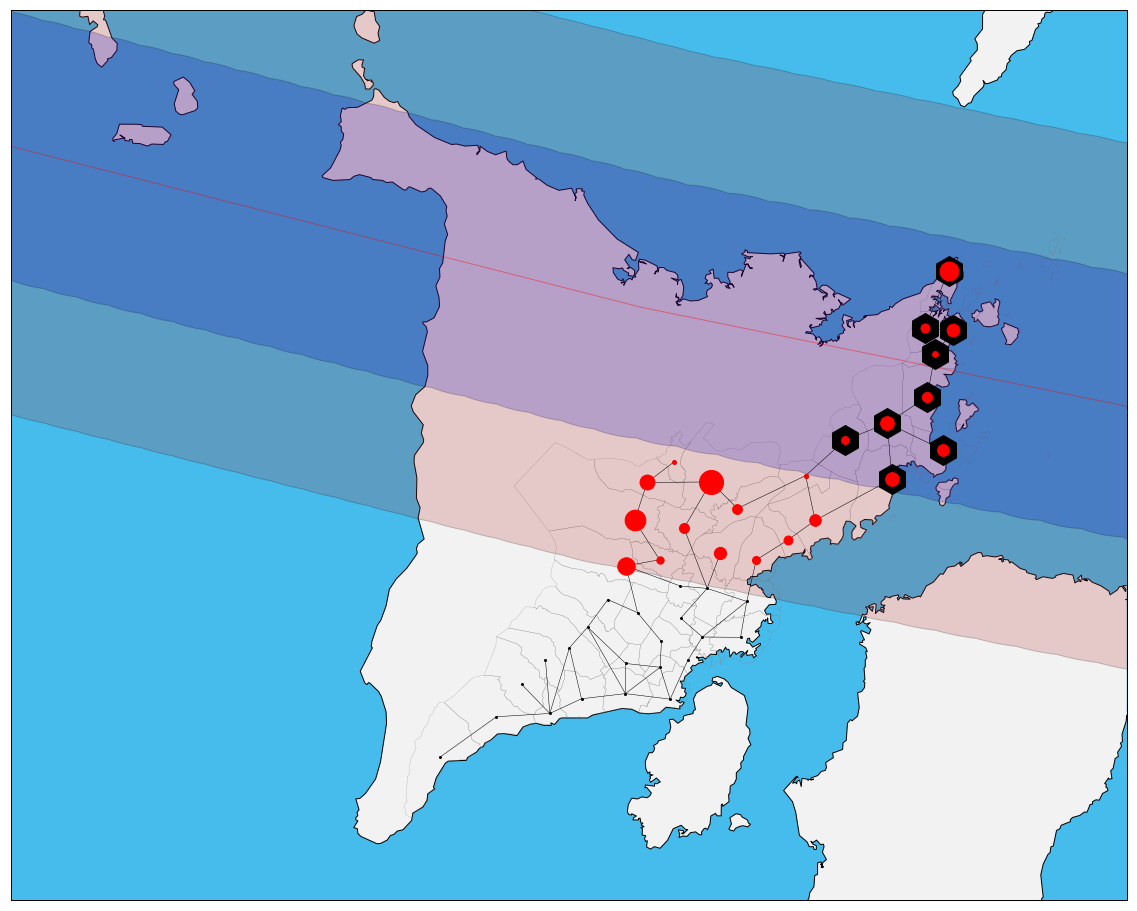

In [258]:
from Circles.circles import circle
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from descartes import PolygonPatch
import numpy as np

#create basemap

lonmin = 121.2
lonmax = 123.5
latmin = 10.3
latmax = 12.1

fig, ax = plt.subplots(figsize=(20,20))
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            llcrnrlon=lonmin, llcrnrlat= latmin, urcrnrlon=lonmax, urcrnrlat=latmax)

#draw best track
besttrackdf = besttrackdf[(besttrackdf[['Latitude','Longitude']] != 0).all(axis=1)]
q,r = m(besttrackdf['Longitude'].tolist(), besttrackdf['Latitude'].tolist())
m.plot(q, r, marker="o", markersize=0.1, linewidth=1, zorder=2, color = 'red', alpha = 0.4)

#generate best track affected area
forecastcone2 = generatebesttrackcone(besttrackdf,30,m)
mapforecastcone2 = PolygonPatch(forecastcone2, fc='#B22222', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone2)

#generate best track affected area (supply destroyed)
forecastcone3 = generatebesttrackcone2(besttrackdf,30,m)
mapforecastcone3 = PolygonPatch(forecastcone3, fc='#0000CD', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone3)

#draw map boundaries
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

#draw town centers
x,y = m(towns['longitude'].tolist(), towns['latitude'].tolist())
m.plot(x, y, 'ko', markersize=2, zorder=5)

#draw town centers demand
a,b = m(visDPs['longitude'].tolist(), visDPs['latitude'].tolist())
c = visDPs['size'].tolist()
for a1, b1, c1 in zip (a,b,c):
    m.plot(a1, b1, 'ro', markersize=c1, zorder=6)

#draw town centers of destroyed supply
u,v = m(visDPsdest['longitude'].tolist(), visDPsdest['latitude'].tolist())
m.plot(u, v, 'hk', markersize=30, zorder=4)

#draw damaged supplies

#balik

#draw town borders
m.readshapefile('regionvi', "towns", linewidth = 0.2, color='gray')

#draw roads
for i in range(len(roads)):
    roadlon = [roads['startlon'][i],roads['endlon'][i]]
    roadlat = [roads['startlat'][i],roads['endlat'][i]]
    q,r = m(roadlon,roadlat)
    m.plot(q,r, marker=None, linewidth = 0.5, color='black')

## Remaining Potential Connections

In some cases, the potential track can cause disruptions to the transportation network. The function roaddamagedjikstralist returns a table which determines whether a point is reachable to another point based on the roadnetwork damage.

In [ ]:
compcijlist = list()
compmijlist = list()
for i in range(len(compDPslist)):
    print(i)
    mijlist, cijlist = roaddamagedjikstralist(compDPslist[i], towns, roads, traveltime, costtable)
    compcijlist.append(cijlist)
    compmijlist.append(mijlist)

# Generate Constant Model Input Parameters

## Generate Shortest Travel Time Table, Travel Time Binary Table, and Cost Table

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
Q = nx.Graph()
#cost of shipping (per FFP item per km)
truck = .0631
roro = 0.209

#add nodes
for i in range(len(towns)):
    Q.add_node(towns['Code'][i],name=towns['Municipality'][i], pos=(towns['longitude'][i],towns['latitude'][i]),province=towns['Province'][i],population=towns['Population'][i],lon=towns['longitude'][i],lat=towns['latitude'][i])

#add edges (roads)
for i in range(len(roads)):
    Q.add_edge(int(roads['Start Code'][i]),int(roads['End Code'][i]),length=roads['Distance (km)'][i],traveltime=roads['Distance (km)'][i]/60,vessel='truck',cost=roads['Distance (km)'][i]*truck)

# #add edges (seas)
# for i in range(len(seas)):
#     Q.add_edge(int(seas['Origin'][i]),int(seas['Destination'][i]),length=seas['Distance.miles'][i]*1.60934,traveltime=seas['Distance.miles'][i]*1.60934/29.632,vessel='ro-ro',cost=roads['Distance (km)'][i]*roro)

#Calculate travel time from each point based on the Djikstra algorithm
traveltime = djikstratable(Q,'traveltime')

#Calculate delivery cost per unit from each point based on the Djikstra algorithm
costtable = djikstratable(Q,'cost')

## Generate initial supply table

In [ ]:
RDCloc = [20]
RDCquantity = [30000]
capacityLDC = 7500
capacityRDC = 30000

Supply = pd.DataFrame(np.zeros((len(DPs), 1)))
xiiinit = pd.DataFrame(np.zeros((len(DPs), 1)))
capi = pd.DataFrame(np.zeros((len(DPs), 1)))
Pi = pd.DataFrame(np.zeros((len(DPs), 1)))

for i in range(len(DPs)):
    capi.iloc[i,0] = capacityLDC

for i in range(len(RDCloc)):
    Supply.iloc[RDCloc[i],0]= RDCquantity[i]
    xiiinit.iloc[RDCloc[i],0]= 1
    capi.iloc[RDCloc[i],0] = capacityRDC

## List of all parameters

In [ ]:
# max number of facilities
# p = 10

#transportation time from supply node h to supply node i
mhi = traveltime

#transport cost per unit of relief good from supply node h to supply node i
chi = costtable

#quantity of goods at supply node i before pre-positioning action
Qi = Supply

#Time required to open LDC i
uio = 8

#Cost to open LDC i
cio = 33000

#Capacity of LDC i
capi = capi

#Binary value equal to 1 if supply node is open prior to prepositioning action
xiiinit = xiiinit

#Total budget available from prepositioning
B = 3000000

#Pi dictates which LDC is permanent and cannot be changed. At first forecast, Pi = 0 as everything can be changed.
Pi = Pi

#Total incurred cost
Tcost = 0

## Save Parameter Data to File

In [ ]:
# with open('ILOILOFinalDataParametersEVAL', 'wb') as fp:
#     pickle.dump(mhi, fp)
#     pickle.dump(chi, fp)
#     pickle.dump(Qi, fp)
#     pickle.dump(uio, fp)
#     pickle.dump(cio, fp)
#     pickle.dump(capi, fp)
#     pickle.dump(xiiinit, fp)
#     pickle.dump(B, fp)
#     pickle.dump(Pi, fp)
#     pickle.dump(Tcost, fp)




In [ ]:
# with open('ILOILOHAIYAN100compDPsEVAL', 'wb') as fp:
#     pickle.dump(compDPslist, fp)
#     pickle.dump(compviablelist, fp)

# with open('ILOILOHAIYAN100FijlistEVAL', 'wb') as fp:
#     pickle.dump(compFijlist, fp)

# with open('ILOILOHAIYAN100compcijEVAL', 'wb') as fp:
#     pickle.dump(compcijlist, fp)

# with open('ILOILOHAIYAN100compmijEVAL', 'wb') as fp:
#     pickle.dump(compmijlist, fp)


# Import Input Data (Model Parameters)

In [347]:
with open('ILOILOFinalDataParametersEVAL', 'rb') as fp:
    mhi = pickle.load(fp)
    chi = pickle.load(fp)
    Qi = pickle.load(fp)
    uio = pickle.load(fp)
    cio = pickle.load(fp)
    capi = pickle.load(fp)
    xiiinit = pickle.load(fp)
    B = pickle.load(fp)
    Pi = pickle.load(fp)
    Tcost = pickle.load(fp)

with open('ILOILOHAIYAN100compDPsEVAL', 'rb') as fp:
    compDPslist = pickle.load(fp)
    compviablelist = pickle.load(fp)

with open('ILOILOHAIYAN100FijlistEVAL', 'rb') as fp:
    compFijlist = pickle.load(fp)

with open('ILOILOHAIYAN100compcijEVAL', 'rb') as fp:
    compcijlist = pickle.load(fp)

with open('ILOILOHAIYAN100compmijEVAL', 'rb') as fp:
    compmijlist = pickle.load(fp)



In [348]:
compFijlist[0][0] = compFijlist[0][0]*0+1000

In [349]:
DPslist = compDPslist[0]
cijlist = compcijlist[0]
Fijlist = compFijlist[0]
mijlist = compmijlist[0]
period = 0

In [350]:
with open('FINALILOILOABS', 'rb') as fp:
    ADFlist = pickle.load(fp)
    BDFlist = pickle.load(fp)
    BDF2list = pickle.load(fp)
    keylist = pickle.load(fp)
    Qilist = pickle.load(fp)
    Tcostlist = pickle.load(fp)
    xiiinitlist = pickle.load(fp)
    Pilist = pickle.load(fp)
#     minpreplist = pickle.load(fp)
#     extratimelist = pickle.load(fp)

In [351]:
# aa = ADFlist[-6].iloc[keylist[-6],:]
# aa = aa.iloc[8:]

In [352]:
# yhinew = yhitemplate.copy()
# yhinew.iloc[20,:] = aa
# yhinew.iloc[20,20] = 0

In [353]:
# yhinew = yhitemplate

In [354]:
# yhilist.append(yhinew)

In [518]:
# len(yhilist)

,0
0,7500.0
1,7500.0
2,7500.0
3,7500.0
4,7500.0
5,7500.0
6,7500.0
7,7500.0
8,7500.0
9,7500.0


In [543]:
capi = capi*0+100000
capi.iloc[20,0] = 100000
Qi.iloc[20,0] = 100000

In [544]:
capi

,0
0,100000.0
1,100000.0
2,100000.0
3,100000.0
4,100000.0
5,100000.0
6,100000.0
7,100000.0
8,100000.0
9,100000.0


## Extract Additional Parameters

In [545]:
def runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period):
    DPs = DPslist[solutionnumber]
    LDC = DPs.copy()
    Si = DPs.loc[:,'Supply']
    Dj = DPs.loc[:,'ActualDemand']
    Fij = Fijlist[solutionnumber]
    cij = cijlist[solutionnumber]
    mij = mijlist[solutionnumber]

    m = Model()

    # Add variables


    yhi = {} #flow of goods between supply nodes
    xii = {} #binary value equal to 1 if supply node i is to be opened for pre-positioning
    yij = {} #flow of goods from supply node i to demand node j
    xij = {} #Binary variable equal to 1 if demand node j is allocated to supply node i
    Fi = {} #maximum prepositioning time at supply node i

    #define yhi as integer
    for h in range(len(LDC)):
        for i in range(len(LDC)):
            yhi[(h,i)] = m.addVar(lb=0, vtype=GRB.INTEGER)

    #define xii as binary
    for i in range(len(LDC)):
        xii[i] = m.addVar(vtype=GRB.BINARY)

    #define yij as integer
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                yij[(i,j)] = m.addVar(lb=0, vtype=GRB.INTEGER)

    #define xij as binary
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                xij[(i,j)] = m.addVar(lb=0, vtype=GRB.BINARY)

    #define Fi as integer 
    for i in range(len(LDC)):
        Fi[i] = m.addVar(lb=0, vtype=GRB.INTEGER)

    m.update()

#     4 Ensures that the total number of supply nodes is maximum of p
#     m.addConstr(quicksum(xii[i] for i in range(len(LDC))) <= p)

    #5 ensures flow at node j from all supply nodes is not greater than amount demanded at j
    for j in range(len(DPs)):
        m.addConstr(quicksum(yij[(i,j)] for i in range(len(LDC))) <= Dj[j])

    #6 j is only assigned to i if goods can be delivered from i to j withink K hours
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= xii[i])

    # ensures that if i is assigned to j, that the maximum pre-positioning time at i takes into account the amount of time before the typhoon reaches j
    for i in range(len(LDC)):
        for j in range(len(DPs)):
                m.addConstr(Fi[i] <= (1-xij[(i,j)])*Fij.iloc[i,i] + xij[(i,j)]*Fij.iloc[i,j])

    #7 Ensures that goods can only be prepositioned at i if the time needed for pre-position does not exceed the maximum pre-positioning time allowed at i
    for h in range(len(LDC)):
          for i in range(len(LDC)):
                m.addConstr(mhi.iloc[h,i]*xii[i] +
                            (1-xiiinit.iloc[i,0])*xii[i]*uio 
                            <= 
                            Fi[i]
                           )


    #8 Ensures that there is enough quantity of supply at node i to deliver to node j
    for i in range(len(LDC)):
        m.addConstr(quicksum(yij[(i,j)] for j in range(len(DPs))) 
                    <=
                    Qi.iloc[i,0] 
                    +
                    quicksum(yhi[(h,i)] for h in range(len(LDC))) 
                    -
                    quicksum(yhi[(i,h)] for h in range(len(LDC))) 
                    )

    #9 Ensures that the quantity of goods delivered from LDC i to DPs does not exceed the capacity of the LDC
    for i in range(len(LDC)):
        m.addConstr(xii[i]*capi.iloc[i,0]                
                            >= quicksum(yij[(i,j)] for j in range(len(DPs))))

    #10 Ensures that DP j is served only if j is allocated to i
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(yij[(i,j)] <= 1000000 * xij[(i,j)])

#     #11 Ensures the path is selected for delivery from LDC to DPs is available based on the forecast
#     for i in range(len(LDC)):
#         for j in range(len(DPs)):
#             m.addConstr(xij[(i,j)] <= Rij.iloc[i,j])

    #12 Ensures that supply node h has the quantity needed to deliver to supply node i
    for i in range(len(LDC)):
        m.addConstr(quicksum(yhi[(i,h)] for h in range(len(LDC))) <= Qi.iloc[i,0])
    
    #Ensures that no supply goods are pre-positioned to permanently placed goods
    for h in range(len(LDC)):
        for i in range(len(LDC)):
            m.addConstr(yhi[(i,h)] <= 1000000*(1-Pi.iloc[i,0])*(1-Pi.iloc[h,0]))

    #Ensures that no supply is prepositioned to a node that is potentially destroyed
    for i in range(len(LDC)):
        m.addConstr(quicksum(yhi[(h,i)] for h in range(len(LDC))) <= 1000000*(Si[i]))  
    
    #11 Ensures the path is selected for delivery from LDC to DPs is available based on the forecast
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= (Si[i]))
    
#     #Ensures that the used budget is less than B
#     m.addConstr(quicksum(quicksum(
#                     chi.iloc[h,i]*yhi[(h,i)]
#                     for i in range(len(LDC))) for h in range(len(LDC))) 
#                     +
#                     quicksum(
#                     (1-xiiinit.iloc[i,0])*xii[i]*cio 
# #                         + 
# #                     xiiinit.iloc[i,0]*(1-xii[i])*cic
#                     for i in range(len(LDC)))
#                     +
#                     quicksum(quicksum(
#                     cij.iloc[i,j]*yij[(i,j)]
#                     for i in range(len(LDC))) for j in range(len(LDC))) + Tcost <= B)
        
    m.setParam("MIPGap", 1e-8)
    m.setParam("TimeLimit", 5.0)
    m.setParam("NodefileStart", 0.05)
    # #Set Objective Functions
    # Objective Function 1 Min Costs
    m.setObjectiveN(quicksum(quicksum(
                    chi.iloc[h,i]*yhi[(h,i)]
                    for i in range(len(LDC))) for h in range(len(LDC))) 
                    +
                    quicksum(quicksum(
                    yhi[(h,i)]/7500
                    for i in range(len(LDC))) for h in range(len(LDC))) *cio
                    +
                    quicksum(
                    (1-xiiinit.iloc[i,0])*xii[i]*cio 
#                         + 
#                     xiiinit.iloc[i,0]*(1-xii[i])*cic
                    for i in range(len(LDC)))
                    +
                    quicksum(quicksum(
                    cij.iloc[i,j]*yij[(i,j)]
                    for i in range(len(LDC))) for j in range(len(LDC)))
                    , 
                    index=1, priority=1, weight=1 )

    #Objective Function 2 Min Supply Destroyed
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)]*(mij.iloc[i,j])
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=2, priority=2, weight=1 )

    #Objective Function 3 Max Demand Supplied
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)] 
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=3, priority=3, weight=-1)


    m.optimize()

    variablelist = m.getVars()
    variablelist = [i.x for i in variablelist]

    yhi = pd.DataFrame(np.array(variablelist[:len(DPs)**2]).reshape(len(DPs),len(DPs)))
    xii = pd.DataFrame(variablelist[len(DPs)**2:len(DPs)**2+len(DPs)])
    yij = pd.DataFrame(np.array(variablelist[len(DPs)**2+len(DPs):len(DPs)**2+len(DPs)+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    xij = pd.DataFrame(np.array(variablelist[len(DPs)**2+len(DPs)+len(DPs)**2:len(DPs)**2+len(DPs)+len(DPs)**2+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    Fi = pd.DataFrame(variablelist[len(DPs)**2+len(DPs)+len(DPs)**2+len(DPs)**2:])

    pd.set_option('display.max_columns', None)  
    yhi2 = yhi[(yhi.T != 0).any()]
    xii2 = xii[(xii.T != 0).any()]
    yij2 = yij[(yij.T != 0).any()]
    xij2 = xij[(xij.T != 0).any()]
    Fi2 = Fi[(Fi.T != 0).any()]
    
    costA = yij.copy()
    costB = yhi.copy()
    dyij = yij.copy()
    dist = yij.copy()
    for i in range(len(dyij)):
        for j in range(len(dyij)):
            dyij.iloc[i,j] = yij.iloc[i,j]*(1-Si[i])
            costA.iloc[i,j] = chi.iloc[i,j]*yhi.iloc[i,j] + cij.iloc[i,j]*yij.iloc[i,j]
            dist.iloc[i,j] = yij.iloc[i,j]*cij.iloc[i,j]
            costB.iloc[i,j] = int(yhi.iloc[i,j]/7500)*cio
#     for i in range(len(costB)):
#         costB.iloc[i,0] = (1-xiiinit.iloc[i,0])*xii.iloc[i,0]*cio
    
    Qinew = Qi.copy()
    DD = Qi.copy()
    for i in range(len(Qinew)):
        Qinew.iloc[i,0] = Qi.iloc[i,0] - yhi.sum(axis=1)[i] + yhi.sum(axis=0)[i]
        DD.iloc[i,0] = Qinew.iloc[i,0]*(1-Si[i])
    
    if yij.sum().sum() == 0:
        avedist = 0
    else:
        avedist = dist.sum().sum()/yij.sum().sum()
        
    
    listA = pd.DataFrame(np.zeros((1, 0)))
    listA['Period'] = period
    listA['Solution'] = solutionnumber
    listA['Demand'] = Dj.sum()
    listA['SuppliedDemand'] = yij.sum().sum()
    listA['DestroyedDemand'] = DD.sum().sum()
    listA['AverageDistance'] = avedist
    listA['Cost'] = Tcost + costA.sum().sum() + costB.sum().sum()
    listA['Facilities'] = xii.sum()
    listA = pd.concat([listA, Qinew.T], axis=1)
    return listA, yhi, xii, yij, xij, Fi 

In [546]:
yhilist = list()
xiilist = list()
yijlist = list()
xijlist = list()
Filist = list()
for solutionnumber in range(len(DPslist)):
    if solutionnumber == 0:
        ADF, yhi, xii, yij, xij, Fi = runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period)
    else:
        ADFnew, yhi, xii, yij, xij, Fi = runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period)
        ADF = ADF.append(ADFnew)
    yhilist.append(yhi)
    xiilist.append(xii)
    yijlist.append(yij)
    xijlist.append(xij)
    Filist.append(Fi)
ADF = ADF.reset_index(drop = True)

Changed value of parameter MIPGap to 1e-08
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 5.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter NodefileStart to 0.05
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 11836 rows, 5896 columns and 30931 nonzeros
Variable types: 0 continuous, 5896 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [2e-02, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 9389 rows and 3463 columns
Presolve time: 0.03s
Presol

In [547]:
ADF

,Period,Solution,Demand,SuppliedDemand,DestroyedDemand,AverageDistance,Cost,Facilities,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0,0,85716.0,85716.0,0.0,1.508083,657407.39964,14.0,0.0,0.0,2673.0,2457.0,0.0,2977.0,0.0,8439.0,0.0,1319.0,0.0,4971.0,0.0,0.0,4059.0,3335.0,0.0,0.0,0.0,0.0,14284.0,5815.0,6899.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8023.0,0.0,0.0,0.0,3268.0,0.0,0.0,31481.0,0.0,0.0,0.0,0.0,0.0


In [548]:
# visDPs['ActualDemand'] = DPslist[0]['ActualDemand']
# visDPs['size'] = visDPs['ActualDemand']/10000*30+0.0000001

In [549]:
resultDPs = DPslist[0].copy()

In [550]:
DPslist[0].ActualDemand.sum()

85716.0

In [551]:
yij.sum()

0     4563.0
1        0.0
2     2673.0
3     2457.0
4     3012.0
5     2977.0
6        0.0
7     3876.0
8     1957.0
9     1319.0
10       0.0
11    4971.0
12    6311.0
13    3925.0
14    4059.0
15    3335.0
16       0.0
17    4231.0
18       0.0
19       0.0
20       0.0
21    5815.0
22    6899.0
23       0.0
24    2628.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31    8023.0
32       0.0
33       0.0
34    3403.0
35    3268.0
36       0.0
37       0.0
38    1427.0
39       0.0
40    4587.0
41       0.0
42       0.0
43       0.0
dtype: float64

In [552]:
resultDPs['AmtSupply'] = yhi.sum()
resultDPs.loc[20,'AmtSupply'] = Qi.loc[20,0] - yhi.sum().sum()
resultDPs['AmtSupplysize'] = resultDPs['AmtSupply']/10000*30+0.0000001
resultDPs['AmtRecvd'] = yij.sum()
resultDPs['AmtRecvdsize'] = resultDPs['AmtRecvd']/10000*30+0.0000001
resultDPs['Facility'] = xii
resultDPs.loc[20,'Facility']=0
supplyDPs = resultDPs[resultDPs['Facility']==1].reset_index(drop=True)
rdc = resultDPs.loc[20,:]

In [553]:
resultDPs

,Municipality,Code,latitude,longitude,Population,ActualDemand,Supply,PrepTime,AmtSupply,AmtSupplysize,AmtRecvd,AmtRecvdsize,Facility
0,AJUY,63001000,11.153148,123.016039,47248,4563.0,0,0,0.0,1.000000e-07,4563.0,1.368900e+01,0.0
1,ALIMODIAN,63002000,10.853345,122.389006,37484,0.0,1,1000,0.0,1.000000e-07,0.0,1.000000e-07,0.0
2,ANILAO,63003000,10.989395,122.736612,27486,2673.0,1,0,2673.0,8.019000e+00,2673.0,8.019000e+00,1.0
3,BADIANGAN,63004000,10.989827,122.537240,26218,2457.0,1,0,2457.0,7.371000e+00,2457.0,7.371000e+00,1.0
4,BALASAN,63005000,11.457487,123.083696,29724,3012.0,0,0,0.0,1.000000e-07,3012.0,9.036000e+00,0.0
5,BANATE,63006000,11.029681,122.801587,29543,2977.0,1,0,2977.0,8.931000e+00,2977.0,8.931000e+00,1.0
6,BAROTAC NUEVO,63007000,10.905421,122.716919,51867,0.0,1,1000,0.0,1.000000e-07,0.0,1.000000e-07,0.0
7,BAROTAC VIEJO,63008000,11.069291,122.857832,41470,3876.0,1,0,8439.0,2.531700e+01,3876.0,1.162800e+01,1.0
8,BATAD,63009000,11.405192,123.105126,19385,1957.0,0,0,0.0,1.000000e-07,1957.0,5.871000e+00,0.0
9,BINGAWAN,63010000,11.188468,122.568007,13432,1319.0,1,0,1319.0,3.957000e+00,1319.0,3.957000e+00,1.0


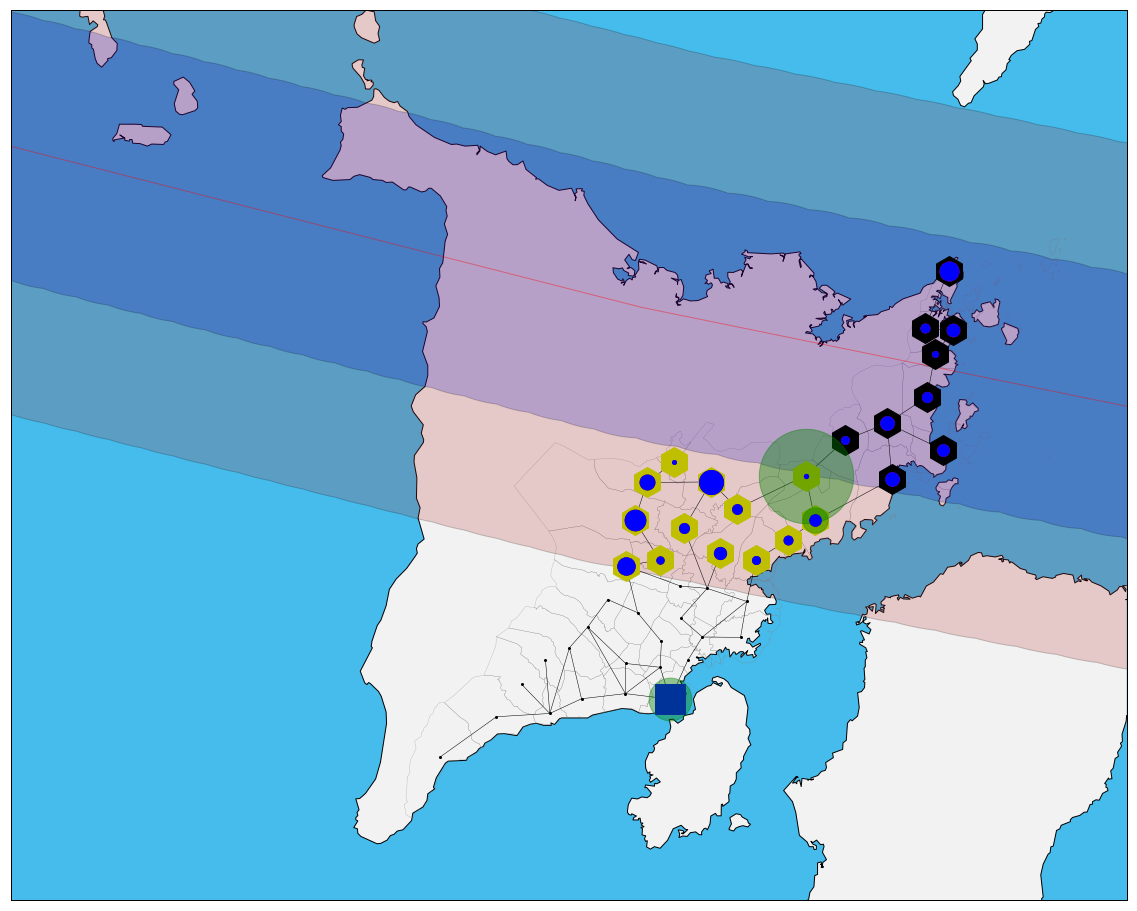

In [554]:
from Circles.circles import circle
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from descartes import PolygonPatch
import numpy as np

#create basemap

lonmin = 121.2
lonmax = 123.5
latmin = 10.3
latmax = 12.1

fig, ax = plt.subplots(figsize=(20,20))
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            llcrnrlon=lonmin, llcrnrlat= latmin, urcrnrlon=lonmax, urcrnrlat=latmax)

#draw best track
besttrackdf = besttrackdf[(besttrackdf[['Latitude','Longitude']] != 0).all(axis=1)]
q,r = m(besttrackdf['Longitude'].tolist(), besttrackdf['Latitude'].tolist())
m.plot(q, r, marker="o", markersize=0.1, linewidth=1, zorder=2, color = 'red', alpha = 0.4)

#generate best track affected area
forecastcone2 = generatebesttrackcone(besttrackdf,30,m)
mapforecastcone2 = PolygonPatch(forecastcone2, fc='#B22222', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone2)

#generate best track affected area (supply destroyed)
forecastcone3 = generatebesttrackcone2(besttrackdf,30,m)
mapforecastcone3 = PolygonPatch(forecastcone3, fc='#0000CD', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone3)

#draw map boundaries
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

#draw town centers
x,y = m(towns['longitude'].tolist(), towns['latitude'].tolist())
m.plot(x, y, 'ko', markersize=2, zorder=3)

#draw town centers demand
a,b = m(visDPs['longitude'].tolist(), visDPs['latitude'].tolist())
c = visDPs['size'].tolist()
for a1, b1, c1 in zip (a,b,c):
    m.plot(a1, b1, 'ro', markersize=c1, zorder=6)

#draw town centers amount supplied
f,g = m(resultDPs['longitude'].tolist(), resultDPs['latitude'].tolist())
h = resultDPs['AmtSupplysize'].tolist()
for as1, bs1, cs1 in zip (f,g,h):
    m.plot(as1, bs1, 'go', markersize=cs1, zorder=6, alpha = 0.4)

#draw town centers amount received
w,x = m(resultDPs['longitude'].tolist(), resultDPs['latitude'].tolist())
y = resultDPs['AmtRecvdsize'].tolist()
for w1, x1, y1 in zip (w,x,y):
    m.plot(w1, x1, 'bo', markersize=y1, zorder=7)

#draw town centers of destroyed supply centers
u,v = m(visDPsdest['longitude'].tolist(), visDPsdest['latitude'].tolist())
m.plot(u, v, 'hk', markersize=30, zorder=4)

#draw supply centers
u,v = m(supplyDPs['longitude'].tolist(), supplyDPs['latitude'].tolist())
m.plot(u, v, 'hy', markersize=30, zorder=4)

#draw RDC
i,j = m(rdc['longitude'], rdc['latitude'].tolist())
m.plot(i, j, 'sb', markersize=30, zorder=4)
#balik

#draw town borders
m.readshapefile('regionvi', "towns", linewidth = 0.2, color='gray')

#draw roads
for i in range(len(roads)):
    roadlon = [roads['startlon'][i],roads['endlon'][i]]
    roadlat = [roads['startlat'][i],roads['endlat'][i]]
    q,r = m(roadlon,roadlat)
    m.plot(q,r, marker=None, linewidth = 0.5, color='black')

In [555]:
# yhitemplate = yhilist[0]*0

In [300]:
def runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost):

    DPs = DPslist[scenarionumber]
    LDC = DPs.copy()
    Si = DPs.loc[:,'Supply']
    Dj = DPs.loc[:,'ActualDemand']
    Fij = Fijlist[scenarionumber]
    cij = cijlist[scenarionumber]
    mij = mijlist[scenarionumber]
    yhi = yhilist[solutionnumber]

    


    m = Model()


    # Add variables


    xii = {} #binary value equal to 1 if supply node i is to be opened for pre-positioning
    yij = {} #flow of goods from supply node i to demand node j
    xij = {} #Binary variable equal to 1 if demand node j is allocated to supply node i
    Fi = {} #maximum prepositioning time at supply node i

    #define xii as binary
    for i in range(len(LDC)):
        xii[i] = m.addVar(vtype=GRB.BINARY)

    #define yij as integer
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                yij[(i,j)] = m.addVar(lb=0, vtype=GRB.INTEGER)

    #define xij as binary
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                xij[(i,j)] = m.addVar(lb=0, vtype=GRB.BINARY)

    #define Fi as integer 
    for i in range(len(LDC)):
        Fi[i] = m.addVar(lb=0, vtype=GRB.INTEGER)

    m.update()


    #5 ensures flow at node j from all supply nodes is not greater than amount demanded at j
    for j in range(len(DPs)):
        m.addConstr(quicksum(yij[(i,j)] for i in range(len(LDC))) <= Dj[j])

    #6 j is only assigned to i if goods can be delivered from i to j withink K hours
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= xii[i])

    # ensures that if i is assigned to j, that the maximum pre-positioning time at i takes into account the amount of time before the typhoon reaches j
    for i in range(len(LDC)):
        for j in range(len(DPs)):
                m.addConstr(Fi[i] <= (1-xij[(i,j)])*Fij.iloc[i,i] + xij[(i,j)]*Fij.iloc[i,j])

    #7 Ensures that goods can only be prepositioned at i if the time needed for pre-position does not exceed the maximum pre-positioning time allowed at i
    for h in range(len(LDC)):
          for i in range(len(LDC)):
                m.addConstr( 
                            mhi.iloc[h,i]*xii[i] +
                            (1-xiiinit.iloc[i,0])*xii[i]*uio 
                            <= 
                            Fi[i]
                           )


    #8 Ensures that there is enough quantity of supply at node i to deliver to node j
    for i in range(len(LDC)):
        m.addConstr(quicksum(yij[(i,j)] for j in range(len(DPs))) 
                    <=
                    Qi.iloc[i,0] - yhi.sum(axis=1)[i] + yhi.sum(axis=0)[i]
                    )

    #9 Ensures that the quantity of goods delivered from LDC i to DPs does not exceed the capacity of the LDC
    for i in range(len(LDC)):
        m.addConstr(xii[i]*capi.iloc[i,0]                
                            >= quicksum(yij[(i,j)] for j in range(len(DPs))))

    #10 Ensures that DP j is served only if j is allocated to i
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(yij[(i,j)] <= 1000000 * xij[(i,j)])

    #11 Ensures the path is selected for delivery from LDC to DPs is available based on the forecast
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= (Si[i]))
    

            
    m.setParam("MIPGap", 1e-8)
    m.setParam("TimeLimit", 5.0)
    m.setParam("NodefileStart", 0.05)
    # #Set Objective Functions
#     Objective Funciton 1 Min Costs
    m.setObjectiveN(quicksum(quicksum(
                    chi.iloc[h,i]*yhi.iloc[h,i]
                    for i in range(len(LDC))) for h in range(len(LDC))) 
                    +
#                     quicksum(
#                     (1-xiiinit.iloc[i,0])*xii[i]*cio 
#                     for i in range(len(LDC)))
                    quicksum(quicksum(
                    yhi.iloc[h,i]/7500
                    for i in range(len(LDC))) for h in range(len(LDC))) *cio
                    +
                    quicksum(quicksum(
                    cij.iloc[i,j]*yij[(i,j)]
                    for i in range(len(LDC))) for j in range(len(LDC)))
                    , 
                    index=1, priority=1, weight=1 )

    #Objective Function 2 Min Supply Destroyed
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)]*(mij.iloc[i,j])
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=2, priority=2, weight=1 )

    #Objective Function 3 Max Demand Supplied
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)] 
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=3, priority=3, weight=-1)



    m.optimize()

    variablelist = m.getVars()
    variablelist = [i.x for i in variablelist]

    xii = pd.DataFrame(variablelist[:len(DPs)])
    yij = pd.DataFrame(np.array(variablelist[len(DPs):len(DPs)+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    xij = pd.DataFrame(np.array(variablelist[len(DPs)+len(DPs)**2:+len(DPs)+len(DPs)**2+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    Fi = pd.DataFrame(variablelist[len(DPs)+len(DPs)**2+len(DPs)**2:])

    pd.set_option('display.max_columns', None)  
    yhi2 = yhi[(yhi.T != 0).any()]
    xii2 = xii[(xii.T != 0).any()]
    yij2 = yij[(yij.T != 0).any()]
    xij2 = xij[(xij.T != 0).any()]
    Fi2 = Fi[(Fi.T != 0).any()]

    costA = yij.copy()
    costB = xiiinit.copy()
    dyhi = Si.copy()
    dist = yij.copy()
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            #costA is the cost of transferring between supply nodes (h to i) and from supply nodes to demand nodes (i to j)
            costA.iloc[i,j] = chi.iloc[i,j]*yhi.iloc[i,j] + cij.iloc[i,j]*yij.iloc[i,j]
            dist.iloc[i,j] = yij.iloc[i,j]*mij.iloc[i,j]*60
#             costB.iloc[i,j] = int(yhi.iloc[i,j]/7500)*cio
            
    for i in range(len(LDC)):
#         costB is the cost of setup (and closure) and opened and closed nodeds
        costB.iloc[i,0] = (1-xiiinit.iloc[i,0])*xii.iloc[i,0]*cio 
#         + xiiinit.iloc[i,0]*(1-xii.iloc[i,0])*cic
        dyhi[i] = (1-Si[i])*yhi.sum(axis=0)[i]

    Qinew = Qi.copy()
    DD = Qi.copy()
    for i in range(len(Qinew)):
        Qinew.iloc[i,0] = Qi.iloc[i,0] - yhi.sum(axis=1)[i] + yhi.sum(axis=0)[i]
        DD.iloc[i,0] = Qinew.iloc[i,0]*(1-Si[i])
    
    
    if yij.sum().sum() == 0:
        avedist = 0
    else:
        avedist = dist.sum().sum()/yij.sum().sum()
       

    listA = pd.DataFrame(np.zeros((1, 0)))
    listA['Period'] = period
    listA['Scenario'] = scenarionumber
    listA['Solution'] = solutionnumber
    listA['Demand'] = Dj.sum()
    listA['SuppliedDemand'] = yij.sum().sum()
    listA['DestroyedDemand'] = DD.sum().sum()
    listA['AverageDistance'] = avedist
    listA['Cost'] = Tcost + costA.sum().sum() + costB.sum()
    listA['Facilities'] = xii.sum()
#     listA = pd.concat([listA, Qinew.T], axis=1)
    
    return listA

In [301]:
for scenarionumber in [0]:
    for solutionnumber in range(len(yhilist)):
        if solutionnumber == 0 and scenarionumber == 0:
            BDF = runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost)
        else:
            BDF = BDF.append(runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost))

Changed value of parameter MIPGap to 1e-08
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 5.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter NodefileStart to 0.05
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 9812 rows, 3960 columns and 21339 nonzeros
Variable types: 0 continuous, 3960 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [2e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 7990 rows and 2134 columns
Presolve time: 0.02s
Presolv

In [302]:
BDF = BDF.reset_index(drop=True)
BDF

,Period,Scenario,Solution,Demand,SuppliedDemand,DestroyedDemand,AverageDistance,Cost,Facilities
0,0,0,0,85716.0,85716.0,0.0,69.306714,7.234074e+05,9.0
1,0,0,1,85716.0,85716.0,0.0,84.938919,4.594074e+05,1.0
2,0,0,2,85716.0,72034.0,27966.0,69.681149,5.212004e+05,1.0
3,0,0,3,85716.0,85716.0,4186.0,74.263840,1.041505e+06,15.0
4,0,0,4,85716.0,77388.0,22612.0,87.826371,9.157496e+05,8.0
5,0,0,5,85716.0,80637.0,19363.0,91.221306,9.039897e+05,7.0
6,0,0,6,85716.0,83796.0,16204.0,94.643673,1.069492e+06,11.0
7,0,0,7,85716.0,85716.0,8107.0,79.705480,1.004481e+06,12.0
8,0,0,8,85716.0,85716.0,0.0,69.306714,7.234074e+05,9.0
9,0,0,9,85716.0,85716.0,0.0,32.798843,9.601616e+05,16.0


In [ ]:
maxSD = list()
mindist = list()
minC = list()

BDF2 = BDF.copy()
for i in range(len(BDF2)):
    if BDF2.loc[i,'Scenario'] == BDF2.loc[i,'Solution']:
        maxSD.append(BDF2.loc[i,'SuppliedDemand'])
        mindist.append(BDF2.loc[i,'AverageDistance'])
        minC.append(BDF2.loc[i,'Cost'])
    
for i in range(len(BDF2)):
    BDF2.loc[i,'SDabs'] = round(BDF2.loc[i,'SuppliedDemand']/BDF2.loc[i,'Demand']*100,2)
#     BDF2.loc[i,'DDabs'] = round(BDF2.loc[i,'DestroyedDemand']/BDF2.loc[i,'Demand']*100,2)
    BDF2.loc[i,'Dstabs'] = BDF2.loc[i,'AverageDistance']
    BDF2.loc[i,'Cabs'] = round(BDF2.loc[i,'Cost'],2)
    BDF2.loc[i, 'SDrel'] = round((maxSD[int(BDF2.loc[i,'Scenario'])] - BDF2.loc[i,'SuppliedDemand'])/ maxSD[int(BDF2.loc[i,'Scenario'])] *100,2)
#     BDF2.loc[i, 'DDrel'] = round((maxSD[int(BDF2.loc[i,'Scenario'])] - BDF2.loc[i,'DestroyedDemand'] )/maxSD[int(BDF2.loc[i,'Scenario'])]*100,2)
    BDF2.loc[i, 'Dstrel'] = round((BDF2.loc[i,'AverageDistance'] - mindist[int(BDF2.loc[i,'Scenario'])] ),2)
    BDF2.loc[i, 'Crel'] = BDF2.loc[i,'Cost'] - minC[int(BDF2.loc[i,'Scenario'])]
    
    
BDFmean = BDF2.groupby(['Solution']).mean()
BDFmax = BDF2.groupby(['Solution']).max()
# BDFmin = BDF3 = BDF2.groupby(['Solution']).min()
BDF2 = pd.concat([BDFmean.iloc[:,:11], BDFmax.iloc[:,11:]], axis=1)
abskey = None
relkey = None

abskeytent = np.argwhere(BDF2.SDabs.tolist() == np.amax(BDF2.SDabs.tolist())).flatten().tolist()
if len(abskeytent) > 1:
    BDF2new = BDF2.loc[abskeytent,:]
    newabskeytent = np.argwhere(BDF2new.Dstabs.tolist() == np.amin(BDF2new.Dstabs.tolist())).flatten().tolist()
    abskeytent = [abskeytent[i] for i in newabskeytent] 
    if len(abskeytent) > 1:
        BDF2new = BDF2.loc[abskeytent,:]
        newabskeytent = np.argwhere(BDF2new.Cabs.tolist() == np.amin(BDF2new.Cabs.tolist())).flatten().tolist()
        abskeytent = [abskeytent[i] for i in newabskeytent] 
abskey = abskeytent[0]


relkeytent = np.argwhere(BDF2.SDrel.tolist() == np.amin(BDF2.SDrel.tolist())).flatten().tolist()
if len(relkeytent) > 1:
    BDF2new = BDF2.loc[relkeytent,:]
    newrelkeytent = np.argwhere(BDF2new.Dstrel.tolist() == np.amin(BDF2new.Dstrel.tolist())).flatten().tolist()
    relkeytent = [relkeytent[i] for i in newrelkeytent ] 
    if len(relkeytent) > 1:
        print(relkeytent)
        BDF2new = BDF2.loc[relkeytent,:]
        newrelkeytent = np.argwhere(BDF2new.Crel.tolist() == np.amin(BDF2new.Crel.tolist())).flatten().tolist()
        relkeytent = [relkeytent[i] for i in newrelkeytent ]
relkey = relkeytent[0]

keycode = 'abs'
    

In [ ]:
abskey

In [ ]:
relkey

In [ ]:
if keycode == 'abs':
    key = abskey
elif keycode == 'rel':
    key = relkey

In [ ]:
minFij = Fijlist[0]*0+500
for i in range(len(Fijlist)):
    for j in range(len(Fijlist[0])):
        for k in range(len(Fijlist[0])):
            minFij.iloc[j,k] = min(Fijlist[i].iloc[j,k],minFij.iloc[j,k])

In [ ]:
#Strategy 1 - pre-position at the last minute

xijnew = xijlist[abskey]
xijnew = xijnew.replace({0:np.nan})
minprep = xijnew*minFij
minprep = minprep.min(axis=1)
minprep = minprep.to_frame()

mhinew = mhi.reset_index(drop=True)
mhinew.columns = range(mhinew.shape[1])
mhinew = mhinew*(yhilist[abskey]/yhilist[abskey])
mhinew = mhinew.max(axis=0).to_frame()
mhinew = mhinew.replace({np.nan:0})

preptime = (1-xiiinit)*xiilist[abskey]*uio + mhinew
extratime = minprep - preptime

for i in range(len(extratime)):
    if extratime.iloc[i,0] < 6:
        Pi.iloc[i,0] = 1

In [ ]:
yhicopy = yhilist[abskey].copy()
for i in range(len(yhilist[abskey])):
    for j in range(len(yhilist[abskey])):
        yhicopy.iloc[i,j] = yhicopy.iloc[i,j]*Pi.iloc[j,0]

for i in range(len(Qi)):
    Qi.iloc[i,0] = Qi.iloc[i,0] - yhicopy.sum(axis=1)[i] + yhicopy.sum(axis=0)[i]

In [ ]:
Tcost1 = yhicopy.copy()
Tcost2 = xiilist[key].copy()
for i in range(len(yhicopy)):
    for j in range(len(yhicopy)):
        Tcost1.iloc[i,j] = chi.iloc[i,j]*yhicopy.iloc[i,j] 
for i in range(len(xiilist[key])):
    Tcost2.iloc[i,0] = (1-xiiinit.iloc[i,0])*(Qi/Qi).iloc[i,0]*cio 

Tcost = Tcost + Tcost1.sum().sum() + Tcost2.sum().sum()
xiiinit = (Qi/Qi).replace({np.nan:0})
Pi.equals(xiilist[key])

In [ ]:
xiilist[key]

In [ ]:
with open('ILOILOFinalDataParameters', 'rb') as fp:
    mhi = pickle.load(fp)
    chi = pickle.load(fp)
    Qi = pickle.load(fp)
    uio = pickle.load(fp)
    cio = pickle.load(fp)
    capi = pickle.load(fp)
    xiiinit = pickle.load(fp)
    B = pickle.load(fp)
    Pi = pickle.load(fp)
    Tcost = pickle.load(fp)

with open('ILOILOHAIYAN100compDPs', 'rb') as fp:
    compDPslist = pickle.load(fp)
    compviablelist = pickle.load(fp)

with open('ILOILOHAIYAN100Fijlist', 'rb') as fp:
    compFijlist = pickle.load(fp)

with open('ILOILOHAIYAN100compcij', 'rb') as fp:
    compcijlist = pickle.load(fp)

with open('ILOILOHAIYAN100compmij', 'rb') as fp:
    compmijlist = pickle.load(fp)


In [ ]:
ADFlist = list()
BDFlist = list()
BDF2list = list()
keylist = list()
Qilist = list()
Tcostlist = list()
xiiinitlist = list()
Pilist = list()
yijmasterlist = list()
minpreplist = list()
extratimelist = list()

for period in range(len(compDPslist)):
    print('period %d' % period)
    if len(compDPslist[period])>1:
        DPslist = compDPslist[period]
        cijlist = compcijlist[period]
        Fijlist = compFijlist[period]
        mijlist = compmijlist[period]

        #RUN MODEL A
        yhilist = list()
        xiilist = list()
        yijlist = list()
        xijlist = list()
        Filist = list()
        for solutionnumber in range(len(DPslist)):
            if solutionnumber == 0:
                ADF, yhi, xii, yij, xij, Fi = runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period)
            else:
                ADFnew, yhi, xii, yij, xij, Fi = runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period)
                ADF = ADF.append(ADFnew)
            yhilist.append(yhi)
            xiilist.append(xii)
            yijlist.append(yij)
            xijlist.append(xij)
            Filist.append(Fi)
        ADF = ADF.reset_index(drop = True)
        
        ADFlist.append(ADF)
        
        
        #RUN MODEL B
        for scenarionumber in range(len(DPslist)):
            for solutionnumber in range(len(DPslist)):
                if solutionnumber == 0 and scenarionumber == 0:
                    BDF = runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost)
                else:
                    BDF = BDF.append(runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost))

        BDF = BDF.reset_index(drop=True)
        BDFlist.append(BDF)
        
        
        #COMPUTE FOR BDF2 TO DETERMINE THE ROBUST SOLUTION
        maxSD = list()
        mindist = list()
        minC = list()

        BDF2 = BDF.copy()
        for i in range(len(BDF2)):
            if BDF2.loc[i,'Scenario'] == BDF2.loc[i,'Solution']:
                maxSD.append(BDF2.loc[i,'SuppliedDemand'])
                mindist.append(BDF2.loc[i,'AverageDistance'])
                minC.append(BDF2.loc[i,'Cost'])

        for i in range(len(BDF2)):
            BDF2.loc[i,'SDabs'] = round(BDF2.loc[i,'SuppliedDemand']/BDF2.loc[i,'Demand']*100,2)
        #     BDF2.loc[i,'DDabs'] = round(BDF2.loc[i,'DestroyedDemand']/BDF2.loc[i,'Demand']*100,2)
            BDF2.loc[i,'Dstabs'] = BDF2.loc[i,'AverageDistance']
            BDF2.loc[i,'Cabs'] = round(BDF2.loc[i,'Cost'],2)
            BDF2.loc[i, 'SDrel'] = round((maxSD[int(BDF2.loc[i,'Scenario'])] - BDF2.loc[i,'SuppliedDemand'])/ maxSD[int(BDF2.loc[i,'Scenario'])] *100,2)
        #     BDF2.loc[i, 'DDrel'] = round((maxSD[int(BDF2.loc[i,'Scenario'])] - BDF2.loc[i,'DestroyedDemand'] )/maxSD[int(BDF2.loc[i,'Scenario'])]*100,2)
            BDF2.loc[i, 'Dstrel'] = round((BDF2.loc[i,'AverageDistance'] - mindist[int(BDF2.loc[i,'Scenario'])] ),2)
            BDF2.loc[i, 'Crel'] = BDF2.loc[i,'Cost'] - minC[int(BDF2.loc[i,'Scenario'])]


        BDFmean = BDF2.groupby(['Solution']).mean()
        BDFmax = BDF2.groupby(['Solution']).max()
        # BDFmin = BDF3 = BDF2.groupby(['Solution']).min()
        BDF2 = pd.concat([BDFmean.iloc[:,:11], BDFmax.iloc[:,11:]], axis=1)
        abskey = None
        relkey = None
        
        BDF2list.append(BDF2)

        abskeytent = np.argwhere(BDF2.SDabs.tolist() == np.amax(BDF2.SDabs.tolist())).flatten().tolist()
        if len(abskeytent) > 1:
            BDF2new = BDF2.loc[abskeytent,:]
            newabskeytent = np.argwhere(BDF2new.Dstabs.tolist() == np.amin(BDF2new.Dstabs.tolist())).flatten().tolist()
            abskeytent = [abskeytent[i] for i in newabskeytent] 
            if len(abskeytent) > 1:
                BDF2new = BDF2.loc[abskeytent,:]
                newabskeytent = np.argwhere(BDF2new.Cabs.tolist() == np.amin(BDF2new.Cabs.tolist())).flatten().tolist()
                abskeytent = [abskeytent[i] for i in newabskeytent] 
        abskey = abskeytent[0]


        relkeytent = np.argwhere(BDF2.SDrel.tolist() == np.amin(BDF2.SDrel.tolist())).flatten().tolist()
        if len(relkeytent) > 1:
            BDF2new = BDF2.loc[relkeytent,:]
            newrelkeytent = np.argwhere(BDF2new.Dstrel.tolist() == np.amin(BDF2new.Dstrel.tolist())).flatten().tolist()
            relkeytent = [relkeytent[i] for i in newrelkeytent ] 
            if len(relkeytent) > 1:
                print(relkeytent)
                BDF2new = BDF2.loc[relkeytent,:]
                newrelkeytent = np.argwhere(BDF2new.Crel.tolist() == np.amin(BDF2new.Crel.tolist())).flatten().tolist()
                relkeytent = [relkeytent[i] for i in newrelkeytent ]
        relkey = relkeytent[0]
        
        #SPECIFY ROBUSTNESS CRITERIA
        keycode = 'abs'
        
        if keycode == 'abs':
            key = abskey
        elif keycode == 'rel':
            key = relkey
        
        keylist.append(key)
        
        #DETERMINE MINIMUM PREP TIME
        minFij = Fijlist[0]*0+500
        for i in range(len(Fijlist)):
            for j in range(len(Fijlist[0])):
                for k in range(len(Fijlist[0])):
                    minFij.iloc[j,k] = min(Fijlist[i].iloc[j,k],minFij.iloc[j,k])
        
        
        #Strategy 1 - pre-position at the last minute
        xijnew = xijlist[abskey]
        xijnew = xijnew.replace({0:np.nan})
        minprep = xijnew*minFij
        minprep = minprep.min(axis=1)
        minprep = minprep.to_frame()

        mhinew = mhi.reset_index(drop=True)
        mhinew.columns = range(mhinew.shape[1])
        mhinew = mhinew*(yhilist[abskey]/yhilist[abskey])
        mhinew = mhinew.max(axis=0).to_frame()
        mhinew = mhinew.replace({np.nan:0})

        preptime = (1-xiiinit)*xiilist[abskey]*uio + mhinew
        extratime = minprep - preptime

        for i in range(len(extratime)):
            if extratime.iloc[i,0] < 6:
                Pi.iloc[i,0] = 1

        yhicopy = yhilist[abskey].copy()
        for i in range(len(yhilist[abskey])):
            for j in range(len(yhilist[abskey])):
                yhicopy.iloc[i,j] = yhicopy.iloc[i,j]*Pi.iloc[j,0]

        for i in range(len(Qi)):
            Qi.iloc[i,0] = Qi.iloc[i,0] - yhicopy.sum(axis=1)[i] + yhicopy.sum(axis=0)[i]

        Tcost1 = yhicopy.copy()
#         Tcost2 = xiilist[key].copy()
        Tcost2 = yhicopy.copy()
        for i in range(len(yhicopy)):
            for j in range(len(yhicopy)):
                Tcost1.iloc[i,j] = chi.iloc[i,j]*yhicopy.iloc[i,j] 
                Tcost2.iloc[i,j] = int(yhi.iloc[i,j]/7500)*cio
                
#         for i in range(len(xiilist[key])):
#             Tcost2.iloc[i,0] = (1-xiiinit.iloc[i,0])*(Qi/Qi).iloc[i,0]*cio 

        Tcost = Tcost + Tcost1.sum().sum() + Tcost2.sum().sum()
        xiiinit = (Qi/Qi).replace({np.nan:0})
        
        print(Pi.equals(xiilist[key]))
        
        minpreplist.append(minprep)
        Qilist.append(Qi)
        Tcostlist.append(Tcost)
        xiiinitlist.append(xiiinit)
        Pilist.append(Pi)
        yijmasterlist.append(yijlist[key])
        extratimelist.append(extratime)
        
        Pifake = Pi.copy()
        Pifake.iloc[7,0] = 1
        
        if Pifake.equals(xiilist[key]):
            break
        
        
        

    
    
    

In [ ]:
BDF2list

In [ ]:
keylist

In [ ]:
minpreplist[-1]

In [ ]:
xiiinitlist[-1]

In [ ]:
Pilist[-1]

In [ ]:
AA = compDPslist.copy()

for period in range(len(compDPslist)):
    for i in range(len(compDPslist[period])):
        if compDPslist[period][i].Supply.sum() == 18:
            AA[period][i] = 0
            compFijlist[period][i] = 0
            compcijlist[period][i] = 0
            compmijlist[period][i] = 0
            
AAlist = list()
BBlist = list()
CClist = list()
DDlist = list()
for period in range(len(AA)):
    A = list()
    B = list()
    C = list()
    D = list()
    for i in range(len(AA[period])):
        if isinstance(AA[period][i], pd.DataFrame):
            A.append(AA[period][i])
            B.append(compFijlist[period][i])
            C.append(compcijlist[period][i])
            D.append(compmijlist[period][i])
    AAlist.append(A)
    BBlist.append(B)
    CClist.append(C)
    DDlist.append(D)

    



In [ ]:
len(compDPslist[3])

In [ ]:
compDPslist = AAlist.copy()[10:13]
compFijlist = BBlist.copy()[10:13]
compcijlist = CClist.copy()[10:13]
compmijlist = DDlist.copy()[10:13]

In [ ]:
compDPslist

In [ ]:
len(compDPslist[-1])

In [ ]:
with open('ILOILOHAIYAN100Fijlist', 'rb') as fp:
    compFijlist = pickle.load(fp)

with open('ILOILOHAIYAN100compcij', 'rb') as fp:
    compcijlist = pickle.load(fp)

with open('ILOILOHAIYAN100compmij', 'rb') as fp:
    compmijlist = pickle.load(fp)

In [ ]:
with open('FINALVIABS48', 'wb') as fp:
    pickle.dump(ADFlist, fp)
    pickle.dump(BDFlist, fp)
    pickle.dump(BDF2list, fp)
    pickle.dump(keylist, fp)
    pickle.dump(Qilist, fp)
    pickle.dump(Tcostlist, fp)
    pickle.dump(xiiinitlist, fp)
    pickle.dump(Pilist, fp)
    pickle.dump(minpreplist, fp)
    pickle.dump(extratimelist, fp)


In [ ]:
minpreplist

In [ ]:
extratimelist

In [ ]:
BDF2list[-1]

In [ ]:
keylist

In [ ]:
extratimelist

In [ ]:
BDF

In [296]:
writer = pd.ExcelWriter('IloiloOutput100K.xlsx')
BDF.to_excel(writer,'Sheet1')
